# Connecting and Uploading

In [ ]:
#loading Last Datasets:
import pandas as pd
dataset_5A = pd.read_pickle("Dataset (5 Authors).pkl")

In [ ]:
# taging:

dataset_5A['Merged'] = "<" + dataset_5A['Label_(number)'].astype(str) + "> " + dataset_5A['Sentence'] + " <end>"# Sentence Merge with their Label

display(dataset_5A.head(3))
print()

#Number of sample in each group:

num_samples = dataset_5A['Author'].value_counts()

display(num_samples)

print("\nSum = ", num_samples.sum())

,Sentence,Charles Dickens,Jane Austen,Mark Twain,Louisa May Alcott,Herman Melville,Author,Label_(number),Label_(tuple),Merged
0,"Why, I have been ashamed of your moroseness th...",1,0,0,0,0,Charles Dickens,0,"(1, 0, 0, 0, 0)","<0> Why, I have been ashamed of your morosenes..."
1,From the blacksmith’s.” “Halloa!” said the ser...,1,0,0,0,0,Charles Dickens,0,"(1, 0, 0, 0, 0)",<0> From the blacksmith’s.” “Halloa!” said the...
2,"Their conversations, however, were not always ...",0,1,0,0,0,Jane Austen,1,"(0, 1, 0, 0, 0)","<1> Their conversations, however, were not alw..."


,count
Author,
Charles Dickens,26856
Mark Twain,25527
Herman Melville,24011
Jane Austen,20044
Louisa May Alcott,19033



Sum =  115471


In [ ]:
# Example:
print(dataset_5A["Sentence"][10])

Gardeners are almost always pleasant, affable people to converse with; but beware of quarter-gunners, keepers of arsenals, and lonely light-house men.


# Evaluator (RoBERTa):

## ---- Data Preperation:

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
!pip install transformers dataset ipython-sql

In [ ]:
!pip install evaluate

In [ ]:
import transformers, datasets, evaluate, pyarrow
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("evaluate:", evaluate.__version__)
print("pyarrow:", pyarrow.__version__)

from transformers import Trainer, TrainingArguments, RobertaTokenizer, RobertaForSequenceClassification
from datasets import Dataset as HFDataset
print("Imports OK")

transformers: 4.55.0
datasets: 2.10.0
evaluate: 0.4.5
pyarrow: 19.0.0
Imports OK


In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset
import evaluate
from datetime import datetime

In [ ]:
dataset_5A.head(3)

,Sentence,Charles Dickens,Jane Austen,Mark Twain,Louisa May Alcott,Herman Melville,Author,Label_(number),Label_(tuple),Merged
0,"Why, I have been ashamed of your moroseness th...",1,0,0,0,0,Charles Dickens,0,"(1, 0, 0, 0, 0)","<0> Why, I have been ashamed of your morosenes..."
1,From the blacksmith’s.” “Halloa!” said the ser...,1,0,0,0,0,Charles Dickens,0,"(1, 0, 0, 0, 0)",<0> From the blacksmith’s.” “Halloa!” said the...
2,"Their conversations, however, were not always ...",0,1,0,0,0,Jane Austen,1,"(0, 1, 0, 0, 0)","<1> Their conversations, however, were not alw..."


In [ ]:
display(dataset_5A['Author'].value_counts())

print("\nSum = ", dataset_5A['Author'].value_counts().sum())


,count
Author,
Charles Dickens,26856
Mark Twain,25527
Herman Melville,24011
Jane Austen,20044
Louisa May Alcott,19033



Sum =  115471


In [ ]:
dataset_BERT = dataset_5A[['Sentence', 'Author']].copy()

In [ ]:
dataset_BERT.head(3)

,Sentence,Author
0,"Why, I have been ashamed of your moroseness th...",Charles Dickens
1,From the blacksmith’s.” “Halloa!” said the ser...,Charles Dickens
2,"Their conversations, however, were not always ...",Jane Austen


In [ ]:
# <0> = Charles Dickens
# <1> = Jane Austen
# <2> = Mark Twain
# <3> = Louisa May Alcott
# <4> = Herman Melville

In [ ]:
# Mapping from year to label
custom_label2id = {
    "Charles Dickens": 0,
    "Jane Austen": 1,
    "Mark Twain": 2,
    "Louisa May Alcott": 3,
    "Herman Melville": 4}

dataset_BERT['Author'] = dataset_BERT['Author'].map(custom_label2id)

dataset_BERT.rename(columns={'Author': 'label'}, inplace=True)

In [ ]:
dataset_BERT.head(3)

,Sentence,label
0,"Why, I have been ashamed of your moroseness th...",0
1,From the blacksmith’s.” “Halloa!” said the ser...,0
2,"Their conversations, however, were not always ...",1


In [ ]:
display(dataset_BERT['label'].value_counts())

print("\n\nTotal Number:", sum(dataset_BERT['label'].value_counts()),"\n\n")

,count
label,
0,26856
2,25527
4,24011
1,20044
3,19033




Total Number: 115471 




In [ ]:
dataset_BERT.rename(columns={'Sentence': 'text'}, inplace=True)
dataset_BERT.rename(columns={'label': 'label'}, inplace=True)
dataset_BERT["label"] = dataset_BERT["label"].astype("int32")
dataset_BERT.head(3)

,text,label
0,"Why, I have been ashamed of your moroseness th...",0
1,From the blacksmith’s.” “Halloa!” said the ser...,0
2,"Their conversations, however, were not always ...",1


In [ ]:
# Check class distribution
num_classes = dataset_BERT["label"].nunique()
print(f"Number of unique Authors (classes): {num_classes}")

Number of unique Authors (classes): 5


In [ ]:
# Split dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    dataset_BERT["text"].tolist(), dataset_BERT["label"].tolist(), test_size=0.2, random_state=42)

## ---- Tokenizing:

In [ ]:
model_name = "roberta-large"

In [ ]:
# Load RoBERTa tokenizer
###tokenizer = RobertaTokenizer.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

max_length = 256

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=max_length)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Convert to Hugging Face Dataset format
train_data = HFDataset.from_dict({"text": train_texts, "label": train_labels})
test_data  = HFDataset.from_dict({"text": test_texts,  "label": test_labels })

In [ ]:
# Tokenize datasets
train_data = train_data.map(tokenize_function, batched=True)
test_data  = test_data.map(tokenize_function,  batched=True)

Map:   0%|          | 0/92376 [00:00<?, ? examples/s]

Map:   0%|          | 0/23095 [00:00<?, ? examples/s]

## ---- Training:

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Some models return (logits, ...) — keep only the first
    if isinstance(logits, tuple):
        logits = logits[0]
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [ ]:
# Load pre-trained RoBERTa model for classification

model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

In [ ]:
# Define paths and filenames
base_dir = '/content/drive/MyDrive/Colab/LLMs Project' # Local directory for saving
current_date = datetime.now().strftime("%Y.%m.%d")

# Define save paths in Google Drive with date
model_path     = f'{base_dir}/roberta_author_classifier/saved_model_{current_date}'
tokenizer_path = f'{base_dir}/roberta_author_classifier/saved_tokenizer_{current_date}'
output_dir           = f'{base_dir}/roberta_author_classifier/results_{current_date}'
logging_dir          = f'{base_dir}/roberta_author_classifier/logs_{current_date}'


In [ ]:
print(model_name,":")
print(model_path)
print(tokenizer_path)
print(output_dir)
print(logging_dir)

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,
    gradient_checkpointing=False,     # huge memory saver when True
    bf16=True, # A100
    tf32=True, # A100
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir=logging_dir,
    logging_steps=10,
    logging_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better = True,
    report_to="wandb",
    run_name="deberta-v3-large (5-authors)",
    optim="adamw_torch_fused"
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

In [ ]:
# Train the model
trainer.train()

In [ ]:
model.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

In [ ]:
# Evaluate on the test set
# Evaluate on the test set
results = trainer.evaluate()

# Ensure W&B gets plain scalars (not numpy types)
wandb.log({k: float(v) for k, v in results.items()})

print(f"Test Accuracy: {results.get('eval_accuracy', float('nan')):.4f}")
print(f"Test F1:       {results.get('eval_f1', float('nan')):.4f}")
print(f"Precision:     {results.get('eval_precision', float('nan')):.4f}")
print(f"Recall:        {results.get('eval_recall', float('nan')):.4f}")

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test set
predictions_output = trainer.predict(test_data)
preds = np.argmax(predictions_output.predictions, axis=-1)
labels = predictions_output.label_ids

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Print or plot the confusion matrix
#print("Confusion Matrix:\n", cm)

# Define the sorted list of years as labels
year_labels = ["Charles Dickens",
               "Jane Austen",
               "Mark Twain",
               "Louisa May Alcott",
               "Herman Melville"]

# Optional: use seaborn to plot a nice heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=year_labels, yticklabels=year_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## ---- Loading:

In [ ]:
ls

'=2.0'                                LLMs_Project_2025.05.08.ipynb
'Dataset (5 Authors).pkl'             LLMs_Project.ipynb
'Final Report.pdf'                    LoRa/
 fine_tuned_model_gptNeo_1.3B/       'NAACL SRW 2025 - Poster.pdf'
 fine_tuned_model_gptNeo_1.3B_lora/   QLoRA/
 generated_texts_gpt3.csv             results/
 generated_texts_gpt3_lora.csv        roberta_author_classifier/
 LLMs_Project_2025.05.06.ipynb        wandb/


In [ ]:
roberta_model_path      = 'roberta_author_classifier/saved_model_2025.08.10'
roberta_tokenizer_path  = 'roberta_author_classifier/saved_tokenizer_2025.08.10'
roberta_output_dir      = 'roberta_author_classifier/results_2025.08.10'
#roberta_logging_dir    = 'roberta_author_classifier/logs_2025.05.07'

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

model = RobertaForSequenceClassification.from_pretrained(roberta_model_path)
tokenizer = RobertaTokenizer.from_pretrained(roberta_tokenizer_path)

# Evaluator (Deberta-v3-Large):

## ---- Data Preperation:

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
!pip install transformers dataset ipython-sql

In [ ]:
!pip install evaluate

In [ ]:
import transformers, datasets, evaluate, pyarrow
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("evaluate:", evaluate.__version__)
print("pyarrow:", pyarrow.__version__)

from transformers import Trainer, TrainingArguments, RobertaTokenizer, RobertaForSequenceClassification
from datasets import Dataset as HFDataset
print("Imports OK")

transformers: 4.55.0
datasets: 2.10.0
evaluate: 0.4.5
pyarrow: 19.0.0
Imports OK


In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset
import evaluate
from datetime import datetime

In [ ]:
dataset_5A.head(3)

,Sentence,Charles Dickens,Jane Austen,Mark Twain,Louisa May Alcott,Herman Melville,Author,Label_(number),Label_(tuple),Merged
0,"Why, I have been ashamed of your moroseness th...",1,0,0,0,0,Charles Dickens,0,"(1, 0, 0, 0, 0)","<0> Why, I have been ashamed of your morosenes..."
1,From the blacksmith’s.” “Halloa!” said the ser...,1,0,0,0,0,Charles Dickens,0,"(1, 0, 0, 0, 0)",<0> From the blacksmith’s.” “Halloa!” said the...
2,"Their conversations, however, were not always ...",0,1,0,0,0,Jane Austen,1,"(0, 1, 0, 0, 0)","<1> Their conversations, however, were not alw..."


In [ ]:
display(dataset_5A['Author'].value_counts())

print("\nSum = ", dataset_5A['Author'].value_counts().sum())


,count
Author,
Charles Dickens,26856
Mark Twain,25527
Herman Melville,24011
Jane Austen,20044
Louisa May Alcott,19033



Sum =  115471


In [ ]:
dataset_BERT = dataset_5A[['Sentence', 'Author']].copy()

In [ ]:
dataset_BERT.head(3)

,Sentence,Author
0,"Why, I have been ashamed of your moroseness th...",Charles Dickens
1,From the blacksmith’s.” “Halloa!” said the ser...,Charles Dickens
2,"Their conversations, however, were not always ...",Jane Austen


In [ ]:
# <0> = Charles Dickens
# <1> = Jane Austen
# <2> = Mark Twain
# <3> = Louisa May Alcott
# <4> = Herman Melville

In [ ]:
# Mapping from year to label
custom_label2id = {
    "Charles Dickens": 0,
    "Jane Austen": 1,
    "Mark Twain": 2,
    "Louisa May Alcott": 3,
    "Herman Melville": 4}

dataset_BERT['Author'] = dataset_BERT['Author'].map(custom_label2id)

dataset_BERT.rename(columns={'Author': 'label'}, inplace=True)

In [ ]:
dataset_BERT.head(3)

,Sentence,label
0,"Why, I have been ashamed of your moroseness th...",0
1,From the blacksmith’s.” “Halloa!” said the ser...,0
2,"Their conversations, however, were not always ...",1


In [ ]:
display(dataset_BERT['label'].value_counts())

print("\n\nTotal Number:", sum(dataset_BERT['label'].value_counts()),"\n\n")

,count
label,
0,26856
2,25527
4,24011
1,20044
3,19033




Total Number: 115471 




In [ ]:
dataset_BERT.rename(columns={'Sentence': 'text'}, inplace=True)
dataset_BERT.rename(columns={'label': 'label'}, inplace=True)
dataset_BERT["label"] = dataset_BERT["label"].astype("int32")
dataset_BERT.head(3)

,text,label
0,"Why, I have been ashamed of your moroseness th...",0
1,From the blacksmith’s.” “Halloa!” said the ser...,0
2,"Their conversations, however, were not always ...",1


In [ ]:
# Check class distribution
num_classes = dataset_BERT["label"].nunique()
print(f"Number of unique Authors (classes): {num_classes}")

Number of unique Authors (classes): 5


In [ ]:
# Split dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    dataset_BERT["text"].tolist(), dataset_BERT["label"].tolist(), test_size=0.2, random_state=42)

In [ ]:
model_name = "microsoft/deberta-v3-large"

## ---- Tokenizing:

In [ ]:
import os, torch
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.set_float32_matmul_precision("high")  # enables TF32

In [ ]:
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments,
    EarlyStoppingCallback
)

model_name = "microsoft/deberta-v3-large"

In [ ]:
# Load RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

max_length = 512 ### 512

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=max_length)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Convert to Hugging Face Dataset format
train_data = HFDataset.from_dict({"text": train_texts, "label": train_labels})
test_data  = HFDataset.from_dict({"text": test_texts,  "label": test_labels })

In [ ]:
# Tokenize datasets
train_data = train_data.map(tokenize_function, batched=True)
test_data  = test_data.map(tokenize_function,  batched=True)

Map:   0%|          | 0/92376 [00:00<?, ? examples/s]

Map:   0%|          | 0/23095 [00:00<?, ? examples/s]

## ---- Training:

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Some models return (logits, ...) — keep only the first
    if isinstance(logits, tuple):
        logits = logits[0]
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

import numpy as np
print("Label set (train):", set(np.unique(train_data["label"])))
print("Label set (test): ", set(np.unique(test_data["label"])))
assert max(train_data["label"] + test_data["label"]) < num_classes, "Found label >= num_labels"
assert min(train_data["label"] + test_data["label"]) >= 0, "Found negative label"

Label set (train): {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Label set (test):  {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}


In [ ]:
# Load pre-trained RoBERTa model for classification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
)

# Important with gradient checkpointing:
model.config.use_cache = False

# Use non-reentrant checkpointing if your Transformers supports it (4.38+)
if hasattr(model, "gradient_checkpointing_enable"):
    try:
        model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
    except TypeError:
        # older versions don't accept kwargs; will still enable GC (reentrant)
        model.gradient_checkpointing_enable()

# Required on some stacks so the first layer gets grads with GC:
if hasattr(model, "enable_input_require_grads"):
    model.enable_input_require_grads()

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define paths and filenames
base_dir = '/content/drive/MyDrive/Colab/LLMs Project' # Local directory for saving
current_date = datetime.now().strftime("%Y.%m.%d")

# Define save paths in Google Drive with date
deberta_model_path     = f'{base_dir}/Deberta_v3_large_author_classifier/saved_model_{current_date}'
deberta_tokenizer_path = f'{base_dir}/Deberta_v3_large_author_classifier/saved_tokenizer_{current_date}'
deberta_output_dir           = f'{base_dir}/Deberta_v3_large_author_classifier/results_{current_date}'
deberta_logging_dir          = f'{base_dir}/Deberta_v3_large_author_classifier/logs_{current_date}'


In [ ]:
print(model_name,":")
print(model_path)
print(tokenizer_path)
print(output_dir)
print(logging_dir)

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir= deberta_output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    gradient_checkpointing=False,     # huge memory saver when True
    bf16=True, # A100
    tf32=True, # A100
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir=deberta_logging_dir,
    logging_steps=10,
    logging_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better = True,
    report_to="wandb",
    run_name="deberta-v3-large (5-authors)",
    optim="adamw_torch_fused"
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    data_collator=data_collator,
    eval_dataset=test_data,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(2)]
)

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.483400,0.447742,0.835419,0.840864,0.835419,0.834983
2,0.372000,0.377335,0.862178,0.867062,0.862178,0.862308
3,0.251700,0.370023,0.872007,0.872553,0.872007,0.871989
4,0.151800,0.409898,0.874518,0.876305,0.874518,0.874486
5,0.100500,0.458274,0.873219,0.874235,0.873219,0.873379
6,0.061900,0.531197,0.876294,0.876369,0.876294,0.876088
7,0.047800,0.553967,0.877766,0.878048,0.877766,0.877707
8,0.034900,0.610145,0.875254,0.876600,0.875254,0.875114
9,0.025300,0.631553,0.877419,0.877991,0.877419,0.877531


TrainOutput(global_step=1629, training_loss=0.20573897224360993, metrics={'train_runtime': 45635.0753, 'train_samples_per_second': 40.485, 'train_steps_per_second': 0.079, 'total_flos': 7.748059087707587e+17, 'train_loss': 0.20573897224360993, 'epoch': 9.0})

In [ ]:
model.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

In [ ]:
# Evaluate on the test set
# Evaluate on the test set
results = trainer.evaluate()

# Ensure W&B gets plain scalars (not numpy types)
wandb.log({k: float(v) for k, v in results.items()})

print(f"Test Accuracy: {results.get('eval_accuracy', float('nan')):.4f}")
print(f"Test F1:       {results.get('eval_f1', float('nan')):.4f}")
print(f"Precision:     {results.get('eval_precision', float('nan')):.4f}")
print(f"Recall:        {results.get('eval_recall', float('nan')):.4f}")

Test Accuracy: 0.8778
Test F1:       0.8777
Precision:     0.8780
Recall:        0.8778


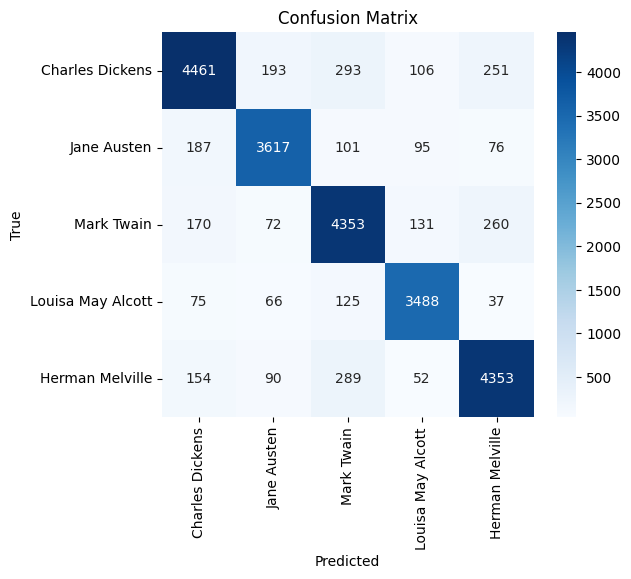

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get predictions on the test set
predictions_output = trainer.predict(test_data)
preds = np.argmax(predictions_output.predictions, axis=-1)
labels = predictions_output.label_ids

# 2. Compute confusion matrix
cm = confusion_matrix(labels, preds)

# 3. Print or plot the confusion matrix
#print("Confusion Matrix:\n", cm)

# Define the sorted list of years as labels
year_labels = ["Charles Dickens",
               "Jane Austen",
               "Mark Twain",
               "Louisa May Alcott",
               "Herman Melville"]

# Optional: use seaborn to plot a nice heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=year_labels, yticklabels=year_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

ECE:  0.0875
MCE:  0.3119
Brier:0.2059
NLL:  0.5540


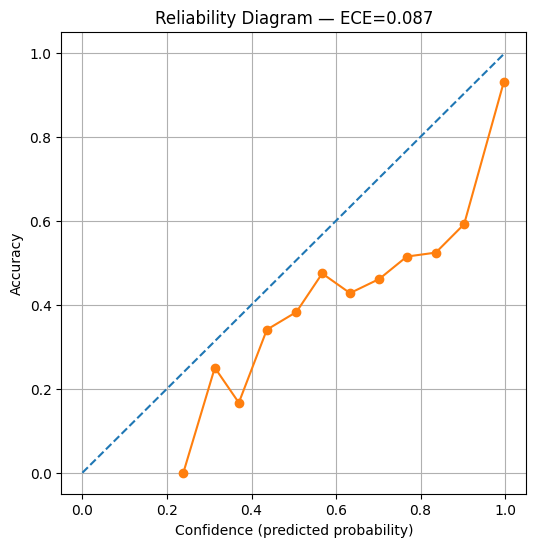

,bin_left,bin_right,bin_count,avg_confidence,avg_accuracy
0,0.000000,0.066667,0,0.033333,NaN
1,0.066667,0.133333,0,0.100000,NaN
2,0.133333,0.200000,0,0.166667,NaN
3,0.200000,0.266667,1,0.238780,0.000000
4,0.266667,0.333333,4,0.313212,0.250000
5,0.333333,0.400000,24,0.370027,0.166667
6,0.400000,0.466667,91,0.436382,0.340659
7,0.466667,0.533333,243,0.506266,0.382716
8,0.533333,0.600000,274,0.567212,0.474453
9,0.600000,0.666667,297,0.632996,0.427609


In [ ]:
# Reliability Diagram (Calibration Curve)

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

# Get logits/labels on the test set
pred_out = trainer.predict(test_data)
logits = pred_out.predictions[0] if isinstance(pred_out.predictions, tuple) else pred_out.predictions  # [N, C]
labels = pred_out.label_ids  # [N]

# Convert to probabilities, confidences, predictions
probs = torch.softmax(torch.tensor(logits), dim=1).cpu().numpy()  # [N, C]
conf = probs.max(axis=1)                                          # [N]
pred = probs.argmax(axis=1)                                       # [N]
correct = (pred == labels).astype(np.float32)                     # [N]

# Reliability diagram bins (+ ECE/MCE)
def reliability_bins(confidences, correct, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(confidences, bins) - 1  # 0..n_bins-1
    bin_acc = np.full(n_bins, np.nan, dtype=np.float32)
    bin_conf = np.full(n_bins, np.nan, dtype=np.float32)
    bin_cnt = np.zeros(n_bins, dtype=np.int64)

    for b in range(n_bins):
        m = (bin_ids == b)
        if np.any(m):
            bin_acc[b] = correct[m].mean()
            bin_conf[b] = confidences[m].mean()
            bin_cnt[b] = m.sum()
        else:
            bin_conf[b] = 0.5 * (bins[b] + bins[b+1])

    ece = np.nansum(np.abs(bin_acc - bin_conf) * (bin_cnt / len(confidences)))
    mce = np.nanmax(np.abs(bin_acc - bin_conf))
    return bins, bin_conf, bin_acc, bin_cnt, ece, mce

bins, bin_conf, bin_acc, bin_cnt, ece, mce = reliability_bins(conf, correct, n_bins=15)

# Brier score (multiclass) + NLL
eye = np.eye(probs.shape[1], dtype=np.float32)
one_hot = eye[labels]                     # [N, C]
brier = np.mean(np.sum((probs - one_hot) ** 2, axis=1))
try:
    nll = log_loss(labels, probs, labels=list(range(probs.shape[1])))
except Exception:
    nll = float("nan")

print(f"ECE:  {ece:.4f}")
print(f"MCE:  {mce:.4f}")
print(f"Brier:{brier:.4f}")
print(f"NLL:  {nll:.4f}")

# Plot reliability diagram (single plot; no specific colors/styles)
valid = ~np.isnan(bin_acc)
plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], linestyle="--")                    # perfect calibration
plt.plot(bin_conf[valid], bin_acc[valid], marker="o")       # model calibration
plt.xlabel("Confidence (predicted probability)")
plt.ylabel("Accuracy")
plt.title(f"Reliability Diagram — ECE={ece:.3f}")
plt.grid(True)
plt.show()

# (Optional) also print a small table of bins
import pandas as pd
calib_df = pd.DataFrame({
    "bin_left": bins[:-1],
    "bin_right": bins[1:],
    "bin_count": bin_cnt,
    "avg_confidence": bin_conf,
    "avg_accuracy": bin_acc,
})
display(calib_df)


## ---- Load Best Checkpoint:

In [ ]:
ls

'=2.0'                                 LLMs_Project_2025.05.08.ipynb
'Dataset (5 Authors).pkl'              LLMs_Project.ipynb
 Deberta_v3_large_author_classifier/   LoRa/
'Final Report.pdf'                    'NAACL SRW 2025 - Poster.pdf'
 fine_tuned_model_gptNeo_1.3B/         QLoRA/
 fine_tuned_model_gptNeo_1.3B_lora/    results/
 generated_texts_gpt3.csv              roberta_author_classifier/
 generated_texts_gpt3_lora.csv         wandb/
 LLMs_Project_2025.05.06.ipynb


In [ ]:
deberta_model_path      = 'Deberta_v3_large_author_classifier/saved_model_2025.08.12'
deberta_tokenizer_path  = 'Deberta_v3_large_author_classifier/saved_tokenizer_2025.08.12'
deberta_output_dir      = 'Deberta_v3_large_author_classifier/results_2025.08.12'
deberta_logging_dir    = 'Deberta_v3_large_author_classifier/logs_2025.08.12'

In [ ]:
import os, json, glob

# Pick the best checkpoint if Trainer recorded it; else fall back to latest
trainer_state_path = os.path.join(deberta_output_dir, "trainer_state.json")
best_ckpt = None
if os.path.isfile(trainer_state_path):
    with open(trainer_state_path, "r") as f:
        st = json.load(f)
    best_ckpt = st.get("best_model_checkpoint", None)

if not best_ckpt:
    ckpts = glob.glob(os.path.join(deberta_output_dir, "checkpoint-*"))
    assert ckpts, "No checkpoints found in results folder."
    ckpts.sort(key=lambda p: int(p.split("-")[-1]))
    best_ckpt = ckpts[-1]

print("Loading checkpoint:", best_ckpt)

Loading checkpoint: Deberta_v3_large_author_classifier/results_2025.08.12/checkpoint-7220


In [ ]:
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments,
    EarlyStoppingCallback
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(best_ckpt)

In [ ]:
# Load tokenizer (you didn’t save one yet, so load from base model id)

base_model_id = "microsoft/deberta-v3-large"
tokenizer = AutoTokenizer.from_pretrained(base_model_id, use_fast=True)

In [ ]:
# (Re)build data collator if needed

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir=deberta_output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    gradient_checkpointing=False,     # huge memory saver when True
    bf16=True, # A100
    tf32=True, # A100
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir=deberta_logging_dir,
    logging_steps=10,
    logging_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better = True,
    report_to="wandb",
    run_name="deberta-v3-large (5-authors)",
    optim="adamw_torch_fused"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,          # reuse your existing TrainingArguments
    train_dataset=train_data,    # or omit if you only want evaluate()
    eval_dataset=test_data,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
#print(trainer.evaluate(metric_key_prefix="test"))

{'test_loss': 0.8301778435707092, 'test_model_preparation_time': 0.0061, 'test_accuracy': 0.8872050227321931, 'test_precision': 0.8873607735274264, 'test_recall': 0.8872050227321931, 'test_f1': 0.8871536603400785, 'test_runtime': 362.5873, 'test_samples_per_second': 63.695, 'test_steps_per_second': 3.982}


In [ ]:
model.save_pretrained(deberta_model_path)
tokenizer.save_pretrained(deberta_tokenizer_path)

print("Saved model to:", deberta_model_path)
print("Saved tokenizer to:", deberta_tokenizer_path)

In [ ]:
#resume training

from dataclasses import replace
from transformers import Trainer

new_args = replace(
    training_args,
    num_train_epochs=training_args.num_train_epochs + 10,  # resume with 10 more epochs
    per_device_train_batch_size=32,      # <= 8 is safe on A100 with DeBERTa-large
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,      # 8 * 4 = 32 effective batch
    gradient_checkpointing=False,
    run_name=(training_args.run_name + "-extra10")
)

trainer = Trainer(
    model=model,
    args=new_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(2)],
)


In [ ]:
trainer.train(resume_from_checkpoint=best_ckpt)

In [ ]:
model.save_pretrained(deberta_model_path)
tokenizer.save_pretrained(deberta_tokenizer_path)

print("Saved model to:", deberta_model_path)
print("Saved tokenizer to:", deberta_tokenizer_path)

## ---- Loading:

In [ ]:
ls

'=2.0'                                 LLMs_Project_2025.05.08.ipynb
'Dataset (5 Authors).pkl'              LLMs_Project.ipynb
 Deberta_v3_large_author_classifier/   LoRa/
'Final Report.pdf'                    'NAACL SRW 2025 - Poster.pdf'
 fine_tuned_model_gptNeo_1.3B/         QLoRA/
 fine_tuned_model_gptNeo_1.3B_lora/    results/
 generated_texts_gpt3.csv              roberta_author_classifier/
 generated_texts_gpt3_lora.csv         wandb/
 LLMs_Project_2025.05.06.ipynb


In [ ]:
deberta_model_path      = 'Deberta_v3_large_author_classifier/saved_model_2025.08.12'
deberta_tokenizer_path  = 'Deberta_v3_large_author_classifier/saved_tokenizer_2025.08.12'
deberta_output_dir      = 'Deberta_v3_large_author_classifier/results_2025.08.12'
#roberta_logging_dir    = 'Deberta_v3_large_author_classifier/logs_2025.08.12'

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(deberta_tokenizer_path, use_fast=True, local_files_only=True)
model     = AutoModelForSequenceClassification.from_pretrained(deberta_model_path, local_files_only=True)
model.config.use_cache = False

# AI-Evaluate-IA

## ---- Evaluation By RoBERTa:

In [ ]:
# First Run Below Subsections in AI-Evaluate-AI Section:
## ---- Data Preperation:
## ---- Loading:

In [ ]:
import pandas as pd

generated_texts_gpt3      = pd.read_csv("generated_texts_gpt3.csv")
generated_texts_gpt3_lora = pd.read_csv("generated_texts_gpt3_lora.csv")

In [ ]:
generated_texts_gpt3['Model'] = 'gpt3'
generated_texts_gpt3_lora['Model'] = 'gpt3_lora'

generated_texts_merged = pd.concat([generated_texts_gpt3, generated_texts_gpt3_lora], ignore_index=True)

In [ ]:
generated_texts_merged['expected_label'] = generated_texts_merged['Text'].str.extract(r'^<(\d+)>').astype(int)

In [ ]:
generated_texts_merged['Text'] = generated_texts_merged['Text'].str.replace(r'^<\d+>', '', regex=True)
generated_texts_merged['Text'] = generated_texts_merged['Text'].str.replace(r'<end>.*', '', regex=True).str.strip()

In [ ]:
generated_texts_merged

,Text,Model,expected_label
0,"It is not my object to enlarge upon her grief,...",gpt3,0
1,It must have been such a blow to her to lose t...,gpt3,1
2,It’s the sickiest place I ever see.,gpt3,2
3,"It’s nothing but a fashionable hair-powder, an...",gpt3,3
4,It was a curious sight to see a ship thus enci...,gpt3,4
...,...,...,...
49995,"Atterry, who had been in the company of the ot...",gpt3_lora,0
49996,Atfelice had now become so much attached to hi...,gpt3_lora,1
49997,Atgrel went to the store to buy some money to ...,gpt3_lora,2
49998,"Atgarts and ladders, all on the topmost step, ...",gpt3_lora,3


In [ ]:
for i in range(1000,1100):
  print(f"{i}: {generated_texts_merged.loc[i,"Model"]} [{generated_texts_merged.loc[i,"expected_label"]}] {generated_texts_merged.loc[i,"Text"]}")

1000: gpt3 [0] ‘Have as many daughters as you please, my dear,’ says my mother.
1001: gpt3 [1] ‘Have you much of your uncle’s society, Mrs. Allen?’ ‘Oh!
1002: gpt3 [2] ‘Have you considered any thing?’ he asked me.
1003: gpt3 [3] ‘Have you got your flannel?’ asked Daisy, with a great deal of curiosity in her face and a great deal of sympathy in her voice.
1004: gpt3 [4] ‘Have your glim, Mr. Stubb,’ said Flask, ‘and let’s see what we’ve got.’ ‘Aye, aye!’ cried Stubb.
1005: gpt3 [0] Already, has my mind received lessons in the sweet art of steering, which, like most other young men’s, I am only too proud to attempt to teach in any other way.
1006: gpt3 [1] Already, has your letter found its way to me; and now I am in earnest.” “Well, my dear,” cried Mrs. Allen, “it is a shame!
1007: gpt3 [2] Already, has St. Paul'--crown prince--settled in his mind the idea that the Saviour was a _red-handed_ murderer, and that iniquitous title to the crown of life was but another name for the deliberate 

In [ ]:
list_generated_texts_merged = generated_texts_merged["Text"].tolist()

In [ ]:
len(list_generated_texts_merged)

50000

In [ ]:
inputs = tokenizer( list_generated_texts_merged,
                    padding=True,
                    truncation=True,
                    return_tensors="pt"
                  )

In [ ]:
# Set model to eval mode
import torch
import pandas as pd
from tqdm.auto import tqdm
import numpy as np

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNo

In [ ]:
# Run predictions

label_map = {
    0: "Charles Dickens",
    1: "Jane Austen",
    2: "Mark Twain",
    3: "Louisa May Alcott",
    4: "Herman Melville"
}

# inputs is a dict of tensors like {'input_ids': ..., 'attention_mask': ...}
N = inputs["input_ids"].shape[0]
bs = 64  # 16/32/64

all_preds = []
all_probs = []   # will hold per-class probabilities

with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    for i in tqdm(range(0, N, bs), desc="Predicting", total=(N + bs - 1)//bs):
        batch = {k: v[i:i+bs].to(device, non_blocking=True) for k, v in inputs.items()}
        logits = model(**batch).logits                         # [B, 5]
        probs  = torch.softmax(logits.float(), dim=1).cpu()    # [B, 5] on CPU
        preds  = probs.argmax(dim=1)

        all_probs.append(probs)
        all_preds.append(preds)

# concat to full arrays
predictions = torch.cat(all_preds)                 # [N]
probs_np = torch.cat(all_probs).numpy()            # [N, 5]

/tmp/ipython-input-46572276.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Predicting:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
# optional: tidy column names
prob_cols = [f"prob_{label_map[i].replace(' ', '_')}" for i in range(5)]

for i, col in enumerate(prob_cols):
    generated_texts_merged[col] = probs_np[:, i]

# keep your predicted labels too
generated_texts_merged["predicted_Label_roberta"] = predictions.numpy()

In [ ]:
generated_texts_merged

,Text,Model,expected_label,prob_Charles_Dickens,prob_Jane_Austen,prob_Mark_Twain,prob_Louisa_May_Alcott,prob_Herman_Melville,predicted_Label_roberta
0,"It is not my object to enlarge upon her grief,...",gpt3,0,0.652461,0.346520,0.000134,0.000124,0.000761,0
1,It must have been such a blow to her to lose t...,gpt3,1,0.000281,0.998954,0.000053,0.000694,0.000018,1
2,It’s the sickiest place I ever see.,gpt3,2,0.000047,0.000007,0.999843,0.000073,0.000030,2
3,"It’s nothing but a fashionable hair-powder, an...",gpt3,3,0.000105,0.000072,0.000770,0.999038,0.000016,3
4,It was a curious sight to see a ship thus enci...,gpt3,4,0.000017,0.000025,0.000015,0.000015,0.999927,4
...,...,...,...,...,...,...,...,...,...
49995,"Atterry, who had been in the company of the ot...",gpt3_lora,0,0.975375,0.010704,0.000245,0.000053,0.013624,0
49996,Atfelice had now become so much attached to hi...,gpt3_lora,1,0.155153,0.774202,0.065026,0.002552,0.003067,1
49997,Atgrel went to the store to buy some money to ...,gpt3_lora,2,0.026309,0.000073,0.024451,0.948486,0.000682,3
49998,"Atgarts and ladders, all on the topmost step, ...",gpt3_lora,3,0.000745,0.001104,0.000036,0.998034,0.000081,3


## ---- Visulization:

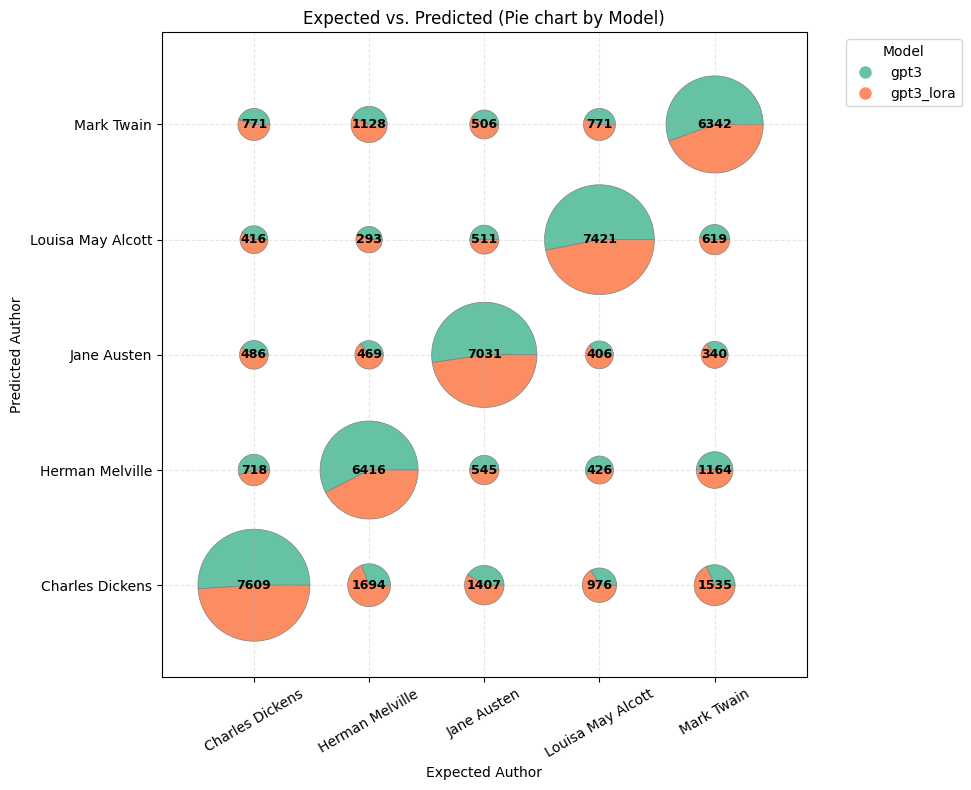

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import numpy as np
import pandas as pd

# Map labels to author names
label_map = {
    0: "Charles Dickens",
    1: "Jane Austen",
    2: "Mark Twain",
    3: "Louisa May Alcott",
    4: "Herman Melville"
}

generated_texts_merged["Expected Author"] = generated_texts_merged["expected_label"].map(label_map)
generated_texts_merged["Predicted Author"] = generated_texts_merged["predicted_Label_roberta"].map(label_map)

# Prepare pie-chart data at each (expected, predicted) coordinate
grouped = (
    generated_texts_merged.groupby(["Expected Author", "Predicted Author", "Model"])
    .size()
    .reset_index(name="Count")
)

# Create a pivot table to get model proportions at each coordinate
pivot = grouped.pivot_table(index=["Expected Author", "Predicted Author"],
                             columns="Model",
                             values="Count",
                             fill_value=0)

# Color map for models
model_colors = dict(zip(pivot.columns, plt.cm.Set2.colors[:len(pivot.columns)]))

# Plot pies at each grid location
fig, ax = plt.subplots(figsize=(10, 8))

x_labels = sorted(pivot.index.get_level_values(0).unique())
y_labels = sorted(pivot.index.get_level_values(1).unique())

# Create mappings for positioning
x_map = {name: i for i, name in enumerate(x_labels)}
y_map = {name: i for i, name in enumerate(y_labels)}

# Draw pies
for (x_label, y_label), row in pivot.iterrows():
    total = row.sum()
    if total == 0:
        continue

    x = x_map[x_label]
    y = y_map[y_label]
    radius = 0.05 + 0.1 * (total / pivot.values.max())  # Adjust pie size

    start_angle = 0
    for model, count in row.items():
        if count == 0:
            continue
        angle = 360 * count / total
        wedge = Wedge(center=(x, y), r=radius,
                      theta1=start_angle, theta2=start_angle + angle,
                      facecolor=model_colors[model],
                      edgecolor='gray', linewidth=0.5)
        ax.add_patch(wedge)
        start_angle += angle

# Configure axis
ax.set_xlim(-0.5 - 0.3, len(x_map) - 0.5 + 0.3)
ax.set_ylim(-0.5 - 0.3, len(y_map) - 0.5 + 0.3)
ax.set_xticks(list(x_map.values()))
ax.set_yticks(list(y_map.values()))
ax.set_xticklabels(x_labels, rotation=30)
ax.set_yticklabels(y_labels)
ax.set_xlabel("Expected Author")
ax.set_ylabel("Predicted Author")
ax.set_title("Expected vs. Predicted (Pie chart by Model)")

for (x_label, y_label), row in pivot.iterrows():
    total = row.sum()
    if total == 0:
        continue

    x = x_map[x_label]
    y = y_map[y_label]
    radius = 0.1 + 0.2 * (total / pivot.values.max())  # smaller pies

    start_angle = 0
    for model, count in row.items():
        if count == 0:
            continue
        angle = 360 * count / total
        wedge = Wedge(center=(x, y), r=radius,
                      theta1=start_angle, theta2=start_angle + angle,
                      facecolor=model_colors[model],
                      edgecolor='gray', linewidth=0.5)
        ax.add_patch(wedge)
        start_angle += angle

    ax.text(
        x, y, str(int(total)),
        ha='center', va='center',
        fontsize=9, weight='bold', color='black'
    )


# Legend
legend_patches = [plt.Line2D([0], [0], marker='o', color='w',
                label=model, markerfacecolor=color, markersize=10)
                for model, color in model_colors.items()]
ax.legend(handles=legend_patches, title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

ax.set_aspect('equal')
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


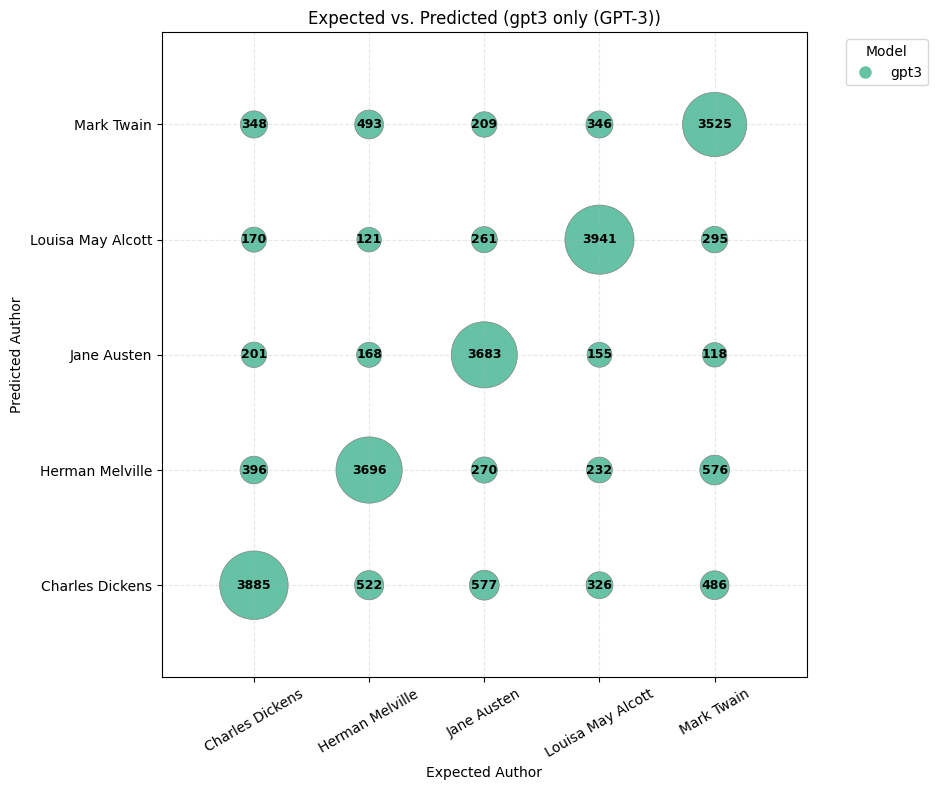

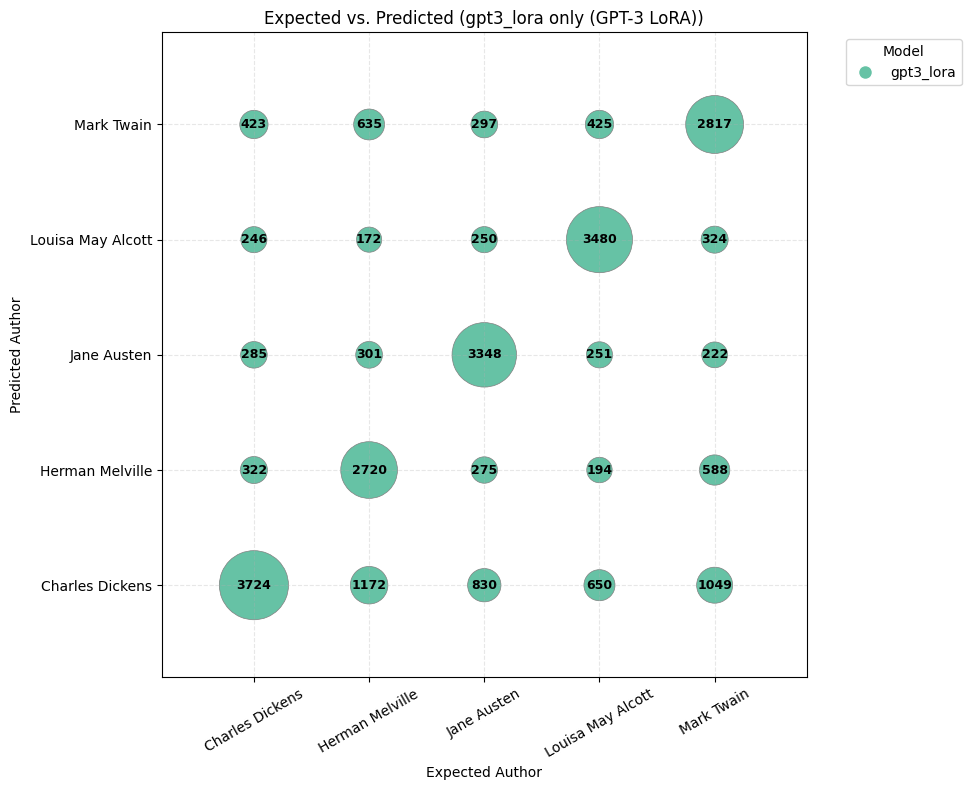

In [ ]:
def plot_pie_chart_for_model(data, model_filter, title_suffix):
    # Filter for a single model
    data = data[data["Model"] == model_filter]

    # Group and pivot
    grouped = (
        data.groupby(["Expected Author", "Predicted Author", "Model"])
        .size()
        .reset_index(name="Count")
    )
    pivot = grouped.pivot_table(
        index=["Expected Author", "Predicted Author"],
        columns="Model",
        values="Count",
        fill_value=0
    )

    # Color map
    model_colors = dict(zip(pivot.columns, plt.cm.Set2.colors[:len(pivot.columns)]))

    # Figure setup
    fig, ax = plt.subplots(figsize=(10, 8))
    x_labels = sorted(pivot.index.get_level_values(0).unique())
    y_labels = sorted(pivot.index.get_level_values(1).unique())
    x_map = {name: i for i, name in enumerate(x_labels)}
    y_map = {name: i for i, name in enumerate(y_labels)}

    # Draw pies
    for (x_label, y_label), row in pivot.iterrows():
        total = row.sum()
        if total == 0:
            continue

        x = x_map[x_label]
        y = y_map[y_label]
        radius = 0.1 + 0.2 * (total / pivot.values.max())

        start_angle = 0
        for model, count in row.items():
            if count == 0:
                continue
            angle = 360 * count / total
            wedge = Wedge(
                center=(x, y), r=radius,
                theta1=start_angle, theta2=start_angle + angle,
                facecolor=model_colors[model],
                edgecolor='gray', linewidth=0.5
            )
            ax.add_patch(wedge)
            start_angle += angle

        ax.text(
            x, y, str(int(total)),
            ha='center', va='center',
            fontsize=9, weight='bold', color='black'
        )

    # Configure axis
    ax.set_xlim(-0.8, len(x_map) - 0.2)
    ax.set_ylim(-0.8, len(y_map) - 0.2)
    ax.set_xticks(list(x_map.values()))
    ax.set_yticks(list(y_map.values()))
    ax.set_xticklabels(x_labels, rotation=30)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel("Expected Author")
    ax.set_ylabel("Predicted Author")
    ax.set_title(f"Expected vs. Predicted ({model_filter} only {title_suffix})")

    # Legend
    legend_patches = [
        plt.Line2D([0], [0], marker='o', color='w',
                   label=model, markerfacecolor=color, markersize=10)
        for model, color in model_colors.items()
    ]
    ax.legend(handles=legend_patches, title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

    ax.set_aspect('equal')
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


# Create the two separate plots
plot_pie_chart_for_model(generated_texts_merged, "gpt3", "(GPT-3)")
plot_pie_chart_for_model(generated_texts_merged, "gpt3_lora", "(GPT-3 LoRA)")


## ---- Analysis:

In [ ]:
generated_texts_merged

,Text,Model,expected_label,prob_Charles_Dickens,prob_Jane_Austen,prob_Mark_Twain,prob_Louisa_May_Alcott,prob_Herman_Melville,predicted_Label_roberta,Expected Author,Predicted Author
0,"It is not my object to enlarge upon her grief,...",gpt3,0,0.652461,0.346520,0.000134,0.000124,0.000761,0,Charles Dickens,Charles Dickens
1,It must have been such a blow to her to lose t...,gpt3,1,0.000281,0.998954,0.000053,0.000694,0.000018,1,Jane Austen,Jane Austen
2,It’s the sickiest place I ever see.,gpt3,2,0.000047,0.000007,0.999843,0.000073,0.000030,2,Mark Twain,Mark Twain
3,"It’s nothing but a fashionable hair-powder, an...",gpt3,3,0.000105,0.000072,0.000770,0.999038,0.000016,3,Louisa May Alcott,Louisa May Alcott
4,It was a curious sight to see a ship thus enci...,gpt3,4,0.000017,0.000025,0.000015,0.000015,0.999927,4,Herman Melville,Herman Melville
...,...,...,...,...,...,...,...,...,...,...,...
49995,"Atterry, who had been in the company of the ot...",gpt3_lora,0,0.975375,0.010704,0.000245,0.000053,0.013624,0,Charles Dickens,Charles Dickens
49996,Atfelice had now become so much attached to hi...,gpt3_lora,1,0.155153,0.774202,0.065026,0.002552,0.003067,1,Jane Austen,Jane Austen
49997,Atgrel went to the store to buy some money to ...,gpt3_lora,2,0.026309,0.000073,0.024451,0.948486,0.000682,3,Mark Twain,Louisa May Alcott
49998,"Atgarts and ladders, all on the topmost step, ...",gpt3_lora,3,0.000745,0.001104,0.000036,0.998034,0.000081,3,Louisa May Alcott,Louisa May Alcott


In [ ]:
# Add diagnostic columns:

In [ ]:
import numpy as np

y_true = generated_texts_merged["expected_label"].to_numpy()
y_pred = generated_texts_merged["predicted_Label_roberta"].to_numpy()

# If you already have probs_np from earlier: shape [N,5]
p_true = probs_np[np.arange(len(probs_np)), y_true]
p_pred = probs_np[np.arange(len(probs_np)), y_pred]
conf   = probs_np.max(axis=1)                       # model confidence
entropy = -np.sum(probs_np * np.log(probs_np + 1e-12), axis=1)  # uncertainty
margin = p_pred - p_true                            # how much more the model preferred pred over true

generated_texts_merged["p_true"] = p_true
generated_texts_merged["p_pred"] = p_pred
generated_texts_merged["confidence"] = conf
generated_texts_merged["entropy"] = entropy
generated_texts_merged["margin"] = margin
generated_texts_merged["is_error"] = (y_true != y_pred)

In [ ]:
generated_texts_merged

,Text,Model,expected_label,prob_Charles_Dickens,prob_Jane_Austen,prob_Mark_Twain,prob_Louisa_May_Alcott,prob_Herman_Melville,predicted_Label_roberta,Expected Author,Predicted Author,p_true,p_pred,confidence,entropy,margin,is_error
0,"It is not my object to enlarge upon her grief,...",gpt3,0,0.652461,0.346520,0.000134,0.000124,0.000761,0,Charles Dickens,Charles Dickens,0.652461,0.652461,0.652461,0.653626,0.000000,False
1,It must have been such a blow to her to lose t...,gpt3,1,0.000281,0.998954,0.000053,0.000694,0.000018,1,Jane Austen,Jane Austen,0.998954,0.998954,0.998954,0.009104,0.000000,False
2,It’s the sickiest place I ever see.,gpt3,2,0.000047,0.000007,0.999843,0.000073,0.000030,2,Mark Twain,Mark Twain,0.999843,0.999843,0.999843,0.001717,0.000000,False
3,"It’s nothing but a fashionable hair-powder, an...",gpt3,3,0.000105,0.000072,0.000770,0.999038,0.000016,3,Louisa May Alcott,Louisa May Alcott,0.999038,0.999038,0.999038,0.008304,0.000000,False
4,It was a curious sight to see a ship thus enci...,gpt3,4,0.000017,0.000025,0.000015,0.000015,0.999927,4,Herman Melville,Herman Melville,0.999927,0.999927,0.999927,0.000866,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,"Atterry, who had been in the company of the ot...",gpt3_lora,0,0.975375,0.010704,0.000245,0.000053,0.013624,0,Charles Dickens,Charles Dickens,0.975375,0.975375,0.975375,0.133964,0.000000,False
49996,Atfelice had now become so much attached to hi...,gpt3_lora,1,0.155153,0.774202,0.065026,0.002552,0.003067,1,Jane Austen,Jane Austen,0.774202,0.774202,0.774202,0.697938,0.000000,False
49997,Atgrel went to the store to buy some money to ...,gpt3_lora,2,0.026309,0.000073,0.024451,0.948486,0.000682,3,Mark Twain,Louisa May Alcott,0.024451,0.948486,0.948486,0.242275,0.924035,True
49998,"Atgarts and ladders, all on the topmost step, ...",gpt3_lora,3,0.000745,0.001104,0.000036,0.998034,0.000081,3,Louisa May Alcott,Louisa May Alcott,0.998034,0.998034,0.998034,0.015977,0.000000,False


In [ ]:
# 2) Where are errors concentrated?

In [ ]:
def author_confusion_table(df):
    """
    Creates a table of confusion stats between Expected Author and Predicted Author.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns:
        - "Expected Author" (string)
        - "Predicted Author" (string)
        - "Text" (any, used for count)
        - "p_true" (float, probability assigned to the true label)
        - "confidence" (float, max predicted probability)

    Returns
    -------
    pandas.DataFrame
        Index: (Expected Author, Predicted Author)
        Columns: n, mean_p_true, mean_conf
        Sorted by n descending.
    """
    tbl = (
        df.groupby(["Expected Author", "Predicted Author"])
          .agg(n=("Text", "size"),
               mean_p_true=("p_true", "mean"),
               mean_conf=("confidence", "mean"))
          .sort_values(["n"], ascending=False)
    )
    return tbl

In [ ]:
# Full dataset
full_tbl = author_confusion_table(generated_texts_merged)

# Only GPT-3 samples
gpt3_tbl = author_confusion_table(generated_texts_merged[generated_texts_merged["Model"] == "gpt3"])

# Only GPT-3 LoRA samples
gpt3_lora_tbl = author_confusion_table(generated_texts_merged[generated_texts_merged["Model"] == "gpt3_lora"])

In [ ]:
gpt3_tbl

n  mean_p_true  mean_conf
Expected Author   Predicted Author                               
Louisa May Alcott Louisa May Alcott  3941     0.980884   0.980884
Charles Dickens   Charles Dickens    3885     0.973513   0.973513
Herman Melville   Herman Melville    3696     0.971543   0.971543
Jane Austen       Jane Austen        3683     0.975020   0.975020
Mark Twain        Mark Twain         3525     0.963066   0.963066
Jane Austen       Charles Dickens     577     0.060407   0.886235
Mark Twain        Herman Melville     576     0.070875   0.888707
Herman Melville   Charles Dickens     522     0.060842   0.884621
                  Mark Twain          493     0.084191   0.865085
Mark Twain        Charles Dickens     486     0.061240   0.880336
Charles Dickens   Herman Melville     396     0.078593   0.873445
                  Mark Twain          348     0.078451   0.868287
Louisa May Alcott Mark Twain          346     0.072301   0.862491
                  Charles Dickens     326     0.065089   0.863563
Mark Twain        Louisa May Alcott   295     0.071434   0.888286
Jane Austen       Herman Melville     270     0.042502   0.862796
                  Louisa May Alcott   261     0.041113   0.887048
Louisa May Alcott Herman Melville     232     0.037773   0.834666
Jane Austen       Mark Twain          209     0.046870   0.849154
Charles Dickens   Jane Austen         201     0.048796   0.903191
                  Louisa May Alcott   170     0.069944   0.872025
Herman Melville   Jane Austen         168     0.039422   0.887283
Louisa May Alcott Jane Austen         155     0.059518   0.893291
Herman Melville   Louisa May Alcott   121     0.039075   0.873095
Mark Twain        Jane Austen         118     0.047034   0.831567

In [ ]:
gpt3_lora_tbl

n  mean_p_true  mean_conf
Expected Author   Predicted Author                               
Charles Dickens   Charles Dickens    3724     0.970204   0.970204
Louisa May Alcott Louisa May Alcott  3480     0.976033   0.976033
Jane Austen       Jane Austen        3348     0.966017   0.966017
Mark Twain        Mark Twain         2817     0.949534   0.949534
Herman Melville   Herman Melville    2720     0.953244   0.953244
                  Charles Dickens    1172     0.055620   0.893048
Mark Twain        Charles Dickens    1049     0.055529   0.887262
Jane Austen       Charles Dickens     830     0.063057   0.875022
Louisa May Alcott Charles Dickens     650     0.046856   0.881423
Herman Melville   Mark Twain          635     0.053074   0.881350
Mark Twain        Herman Melville     588     0.058621   0.874904
Louisa May Alcott Mark Twain          425     0.058224   0.869268
Charles Dickens   Mark Twain          423     0.062772   0.880048
Mark Twain        Louisa May Alcott   324     0.067160   0.878613
Charles Dickens   Herman Melville     322     0.071252   0.881054
Herman Melville   Jane Austen         301     0.043158   0.876071
Jane Austen       Mark Twain          297     0.039349   0.855937
Charles Dickens   Jane Austen         285     0.087527   0.870815
Jane Austen       Herman Melville     275     0.050697   0.826225
Louisa May Alcott Jane Austen         251     0.048213   0.881709
Jane Austen       Louisa May Alcott   250     0.038782   0.891814
Charles Dickens   Louisa May Alcott   246     0.069081   0.878201
Mark Twain        Jane Austen         222     0.044742   0.858134
Louisa May Alcott Herman Melville     194     0.033861   0.867745
Herman Melville   Louisa May Alcott   172     0.020713   0.874432

In [ ]:
# 3) Confidence & calibration:

In [ ]:
import numpy as np
import pandas as pd

def calibration_table(df, bins=np.linspace(0, 1, 21)):
    """
    Compute calibration stats (n, acc, mean_conf, gap) by confidence bin.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
        - "confidence": float, predicted max probability
        - "is_error": bool, True if prediction != actual label
        - "Text": used for counting samples
    bins : array-like, optional
        Bin edges for confidence (default: 0.0 to 1.0 in steps of 0.1)

    Returns
    -------
    pandas.DataFrame
        Index: conf_bin (int bin index)
        Columns: n, acc, mean_conf, gap
    """
    df = df.copy()
    df["conf_bin"] = np.digitize(df["confidence"], bins)

    calib = (
        df.groupby("conf_bin")
          .agg(n=("Text", "size"),
               acc=("is_error", lambda x: 1 - x.mean()),
               mean_conf=("confidence", "mean"))
    )
    calib["gap"] = calib["mean_conf"] - calib["acc"]
    return calib


In [ ]:
# Full dataset
full_calib = calibration_table(generated_texts_merged)

# GPT-3 only
gpt3_calib = calibration_table(generated_texts_merged[generated_texts_merged["Model"] == "gpt3"])

# GPT-3 LoRA only
gpt3_lora_calib = calibration_table(generated_texts_merged[generated_texts_merged["Model"] == "gpt3_lora"])

In [ ]:
gpt3_calib

,n,acc,mean_conf,gap
conf_bin,,,,
5,1,1.000000,0.245367,-0.754633
6,30,0.233333,0.265133,0.031799
7,14,0.428571,0.327748,-0.100823
8,38,0.210526,0.376726,0.166200
9,87,0.252874,0.427210,0.174337
10,188,0.202128,0.475221,0.273094
11,329,0.379939,0.527009,0.147070
12,324,0.354938,0.575262,0.220324
13,311,0.363344,0.625521,0.262177


In [ ]:
gpt3_lora_calib

,n,acc,mean_conf,gap
conf_bin,,,,
6,13,0.307692,0.273933,-0.033759
7,21,0.380952,0.335549,-0.045404
8,50,0.240000,0.377893,0.137893
9,113,0.256637,0.427177,0.170539
10,238,0.256303,0.479389,0.223086
11,442,0.339367,0.524497,0.185131
12,474,0.312236,0.575709,0.263472
13,470,0.346809,0.625096,0.278287
14,484,0.334711,0.675792,0.341081


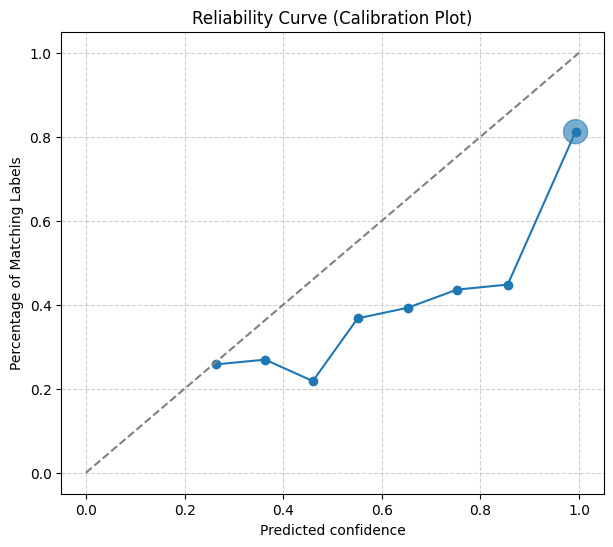

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

calib_for_plot = gpt3_calib.copy() # full_calib \ gpt3_calib \ gpt3_lora_calib

plt.figure(figsize=(7,6))
plt.plot(calib_for_plot["mean_conf"], calib_for_plot["acc"], marker='o', label="Actual accuracy")
plt.plot([0,1],[0,1],'--',color='gray',label="Perfect calibration")

sizes = (calib_for_plot["n"] / calib_for_plot["n"].max()) * 300
plt.scatter(calib_for_plot["mean_conf"], calib_for_plot["acc"], s=sizes, alpha=0.6)

plt.xlabel("Predicted confidence")
plt.ylabel("Percentage of Matching Labels")
plt.title("Reliability Curve (Calibration Plot)")
#plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
generated_texts_merged[generated_texts_merged["Model"] == "gpt3"]

,Text,Model,expected_label,prob_Charles_Dickens,prob_Jane_Austen,prob_Mark_Twain,prob_Louisa_May_Alcott,prob_Herman_Melville,predicted_Label_roberta,Expected Author,Predicted Author,p_true,p_pred,confidence,entropy,margin,is_error
0,"It is not my object to enlarge upon her grief,...",gpt3,0,0.652461,0.346520,0.000134,0.000124,0.000761,0,Charles Dickens,Charles Dickens,0.652461,0.652461,0.652461,0.653626,0.0,False
1,It must have been such a blow to her to lose t...,gpt3,1,0.000281,0.998954,0.000053,0.000694,0.000018,1,Jane Austen,Jane Austen,0.998954,0.998954,0.998954,0.009104,0.0,False
2,It’s the sickiest place I ever see.,gpt3,2,0.000047,0.000007,0.999843,0.000073,0.000030,2,Mark Twain,Mark Twain,0.999843,0.999843,0.999843,0.001717,0.0,False
3,"It’s nothing but a fashionable hair-powder, an...",gpt3,3,0.000105,0.000072,0.000770,0.999038,0.000016,3,Louisa May Alcott,Louisa May Alcott,0.999038,0.999038,0.999038,0.008304,0.0,False
4,It was a curious sight to see a ship thus enci...,gpt3,4,0.000017,0.000025,0.000015,0.000015,0.999927,4,Herman Melville,Herman Melville,0.999927,0.999927,0.999927,0.000866,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,"At you, sir!” “Ah!” said the turnkey, glancing...",gpt3,0,0.999964,0.000010,0.000006,0.000012,0.000008,0,Charles Dickens,Charles Dickens,0.999964,0.999964,0.999964,0.000457,0.0,False
24996,"At once, and without any preparation, she deci...",gpt3,1,0.000046,0.999864,0.000015,0.000053,0.000022,1,Jane Austen,Jane Austen,0.999864,0.999864,0.999864,0.001517,0.0,False
24997,At once the chief mate said: “We have seen str...,gpt3,2,0.000034,0.000096,0.714409,0.000177,0.285285,2,Mark Twain,Mark Twain,0.714409,0.714409,0.714409,0.600836,0.0,False
24998,"At a sign from Demi, they all filed out into t...",gpt3,3,0.000010,0.000023,0.000011,0.999945,0.000011,3,Louisa May Alcott,Louisa May Alcott,0.999945,0.999945,0.999945,0.000670,0.0,False


In [ ]:
high_conf_samples = generated_texts_merged[generated_texts_merged["confidence"] > 0.93]

In [ ]:
high_conf_samples = high_conf_samples.reset_index(drop=True)
high_conf_samples

,Text,Model,expected_label,prob_Charles_Dickens,prob_Jane_Austen,prob_Mark_Twain,prob_Louisa_May_Alcott,prob_Herman_Melville,predicted_Label_roberta,Expected Author,Predicted Author,p_true,p_pred,confidence,entropy,margin,is_error
0,It must have been such a blow to her to lose t...,gpt3,1,0.000281,0.998954,0.000053,0.000694,0.000018,1,Jane Austen,Jane Austen,0.998954,0.998954,0.998954,0.009104,0.000000,False
1,It’s the sickiest place I ever see.,gpt3,2,0.000047,0.000007,0.999843,0.000073,0.000030,2,Mark Twain,Mark Twain,0.999843,0.999843,0.999843,0.001717,0.000000,False
2,"It’s nothing but a fashionable hair-powder, an...",gpt3,3,0.000105,0.000072,0.000770,0.999038,0.000016,3,Louisa May Alcott,Louisa May Alcott,0.999038,0.999038,0.999038,0.008304,0.000000,False
3,It was a curious sight to see a ship thus enci...,gpt3,4,0.000017,0.000025,0.000015,0.000015,0.999927,4,Herman Melville,Herman Melville,0.999927,0.999927,0.999927,0.000866,0.000000,False
4,"When it came to this, I really sat down and wr...",gpt3,0,0.961240,0.010118,0.001168,0.000113,0.027362,0,Charles Dickens,Charles Dickens,0.961240,0.961240,0.961240,0.191852,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40028,"But—but—one has always felt, and I cannot but ...",gpt3_lora,4,0.003904,0.000688,0.000170,0.000033,0.995205,4,Herman Melville,Herman Melville,0.995205,0.995205,0.995205,0.033260,0.000000,False
40029,"Atterry, who had been in the company of the ot...",gpt3_lora,0,0.975375,0.010704,0.000245,0.000053,0.013624,0,Charles Dickens,Charles Dickens,0.975375,0.975375,0.975375,0.133964,0.000000,False
40030,Atgrel went to the store to buy some money to ...,gpt3_lora,2,0.026309,0.000073,0.024451,0.948486,0.000682,3,Mark Twain,Louisa May Alcott,0.024451,0.948486,0.948486,0.242275,0.924035,True
40031,"Atgarts and ladders, all on the topmost step, ...",gpt3_lora,3,0.000745,0.001104,0.000036,0.998034,0.000081,3,Louisa May Alcott,Louisa May Alcott,0.998034,0.998034,0.998034,0.015977,0.000000,False


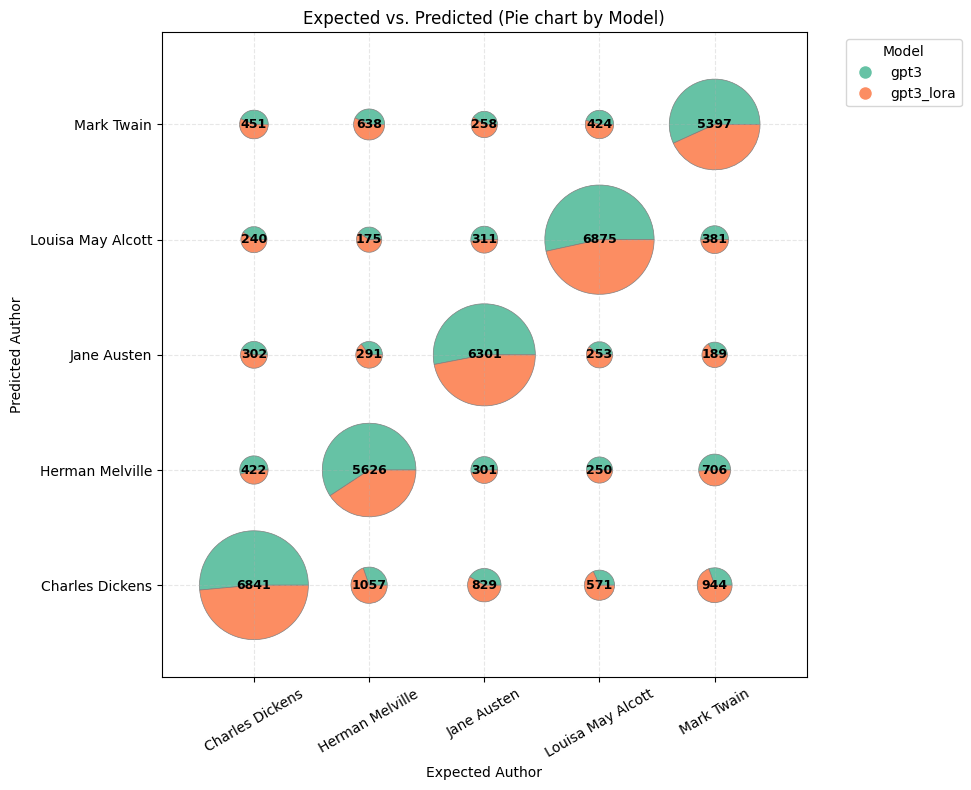

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import numpy as np
import pandas as pd

# Map labels to author names
label_map = {
    0: "Charles Dickens",
    1: "Jane Austen",
    2: "Mark Twain",
    3: "Louisa May Alcott",
    4: "Herman Melville"
}

high_conf_samples["Expected Author"] = high_conf_samples["expected_label"].map(label_map)
high_conf_samples["Predicted Author"] = high_conf_samples["predicted_Label_roberta"].map(label_map)

# Prepare pie-chart data at each (expected, predicted) coordinate
grouped = (
    high_conf_samples.groupby(["Expected Author", "Predicted Author", "Model"])
    .size()
    .reset_index(name="Count")
)

# Create a pivot table to get model proportions at each coordinate
pivot = grouped.pivot_table(index=["Expected Author", "Predicted Author"],
                             columns="Model",
                             values="Count",
                             fill_value=0)

# Color map for models
model_colors = dict(zip(pivot.columns, plt.cm.Set2.colors[:len(pivot.columns)]))

# Plot pies at each grid location
fig, ax = plt.subplots(figsize=(10, 8))

x_labels = sorted(pivot.index.get_level_values(0).unique())
y_labels = sorted(pivot.index.get_level_values(1).unique())

# Create mappings for positioning
x_map = {name: i for i, name in enumerate(x_labels)}
y_map = {name: i for i, name in enumerate(y_labels)}

# Draw pies
for (x_label, y_label), row in pivot.iterrows():
    total = row.sum()
    if total == 0:
        continue

    x = x_map[x_label]
    y = y_map[y_label]
    radius = 0.05 + 0.1 * (total / pivot.values.max())  # Adjust pie size

    start_angle = 0
    for model, count in row.items():
        if count == 0:
            continue
        angle = 360 * count / total
        wedge = Wedge(center=(x, y), r=radius,
                      theta1=start_angle, theta2=start_angle + angle,
                      facecolor=model_colors[model],
                      edgecolor='gray', linewidth=0.5)
        ax.add_patch(wedge)
        start_angle += angle

# Configure axis
ax.set_xlim(-0.5 - 0.3, len(x_map) - 0.5 + 0.3)
ax.set_ylim(-0.5 - 0.3, len(y_map) - 0.5 + 0.3)
ax.set_xticks(list(x_map.values()))
ax.set_yticks(list(y_map.values()))
ax.set_xticklabels(x_labels, rotation=30)
ax.set_yticklabels(y_labels)
ax.set_xlabel("Expected Author")
ax.set_ylabel("Predicted Author")
ax.set_title("Expected vs. Predicted (Pie chart by Model)")

for (x_label, y_label), row in pivot.iterrows():
    total = row.sum()
    if total == 0:
        continue

    x = x_map[x_label]
    y = y_map[y_label]
    radius = 0.1 + 0.2 * (total / pivot.values.max())  # smaller pies

    start_angle = 0
    for model, count in row.items():
        if count == 0:
            continue
        angle = 360 * count / total
        wedge = Wedge(center=(x, y), r=radius,
                      theta1=start_angle, theta2=start_angle + angle,
                      facecolor=model_colors[model],
                      edgecolor='gray', linewidth=0.5)
        ax.add_patch(wedge)
        start_angle += angle

    ax.text(
        x, y, str(int(total)),
        ha='center', va='center',
        fontsize=9, weight='bold', color='black'
    )


# Legend
legend_patches = [plt.Line2D([0], [0], marker='o', color='w',
                label=model, markerfacecolor=color, markersize=10)
                for model, color in model_colors.items()]
ax.legend(handles=legend_patches, title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

ax.set_aspect('equal')
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

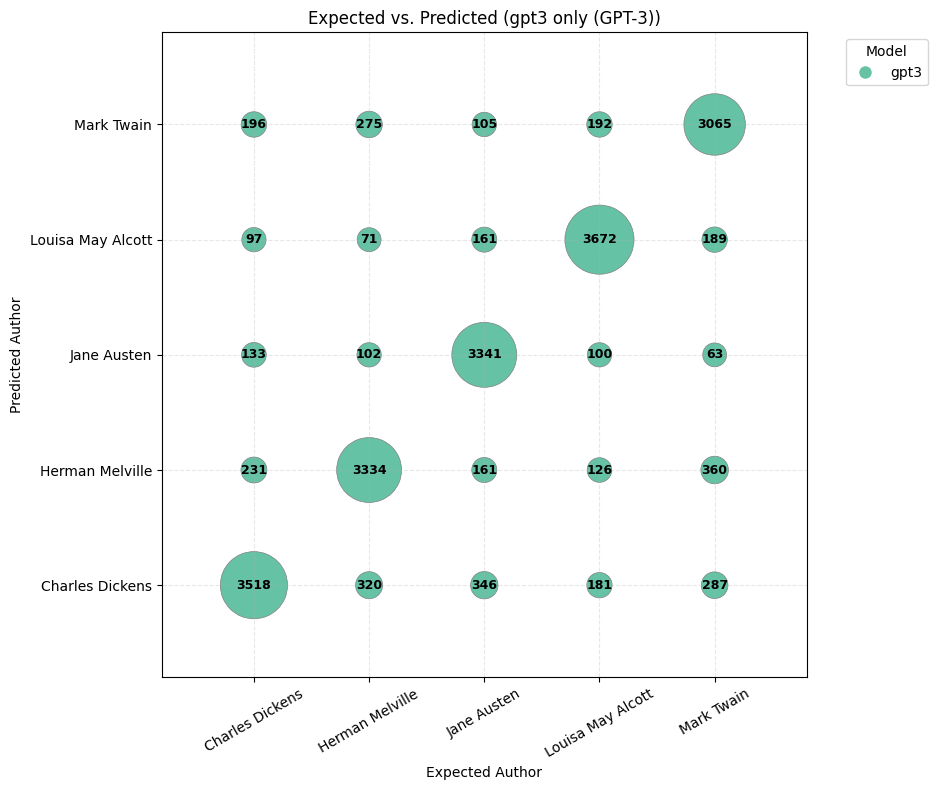

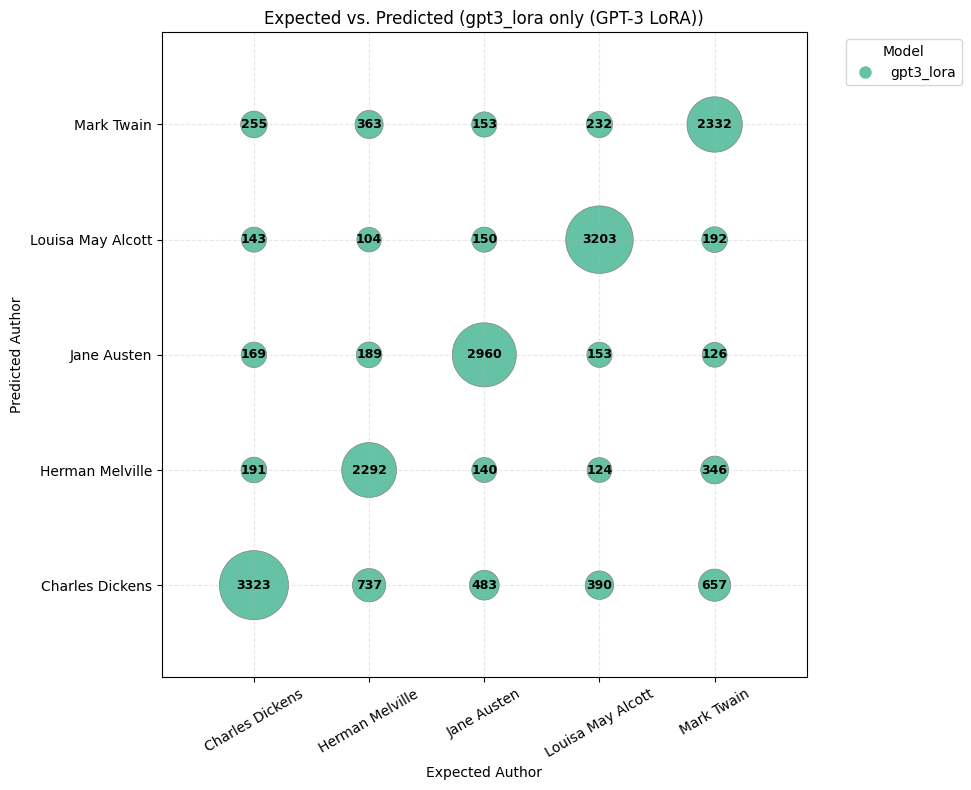

In [ ]:
def plot_pie_chart_for_model(data, model_filter, title_suffix):
    # Filter for a single model
    data = data[data["Model"] == model_filter]

    # Group and pivot
    grouped = (
        data.groupby(["Expected Author", "Predicted Author", "Model"])
        .size()
        .reset_index(name="Count")
    )
    pivot = grouped.pivot_table(
        index=["Expected Author", "Predicted Author"],
        columns="Model",
        values="Count",
        fill_value=0
    )

    # Color map
    model_colors = dict(zip(pivot.columns, plt.cm.Set2.colors[:len(pivot.columns)]))

    # Figure setup
    fig, ax = plt.subplots(figsize=(10, 8))
    x_labels = sorted(pivot.index.get_level_values(0).unique())
    y_labels = sorted(pivot.index.get_level_values(1).unique())
    x_map = {name: i for i, name in enumerate(x_labels)}
    y_map = {name: i for i, name in enumerate(y_labels)}

    # Draw pies
    for (x_label, y_label), row in pivot.iterrows():
        total = row.sum()
        if total == 0:
            continue

        x = x_map[x_label]
        y = y_map[y_label]
        radius = 0.1 + 0.2 * (total / pivot.values.max())

        start_angle = 0
        for model, count in row.items():
            if count == 0:
                continue
            angle = 360 * count / total
            wedge = Wedge(
                center=(x, y), r=radius,
                theta1=start_angle, theta2=start_angle + angle,
                facecolor=model_colors[model],
                edgecolor='gray', linewidth=0.5
            )
            ax.add_patch(wedge)
            start_angle += angle

        ax.text(
            x, y, str(int(total)),
            ha='center', va='center',
            fontsize=9, weight='bold', color='black'
        )

    # Configure axis
    ax.set_xlim(-0.8, len(x_map) - 0.2)
    ax.set_ylim(-0.8, len(y_map) - 0.2)
    ax.set_xticks(list(x_map.values()))
    ax.set_yticks(list(y_map.values()))
    ax.set_xticklabels(x_labels, rotation=30)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel("Expected Author")
    ax.set_ylabel("Predicted Author")
    ax.set_title(f"Expected vs. Predicted ({model_filter} only {title_suffix})")

    # Legend
    legend_patches = [
        plt.Line2D([0], [0], marker='o', color='w',
                   label=model, markerfacecolor=color, markersize=10)
        for model, color in model_colors.items()
    ]
    ax.legend(handles=legend_patches, title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

    ax.set_aspect('equal')
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


# Create the two separate plots
plot_pie_chart_for_model(high_conf_samples, "gpt3", "(GPT-3)")
plot_pie_chart_for_model(high_conf_samples, "gpt3_lora", "(GPT-3 LoRA)")


In [ ]:
def correct_percentages(df):
    result = (
        df.groupby("Model")["is_error"]
        .agg(
            total_samples="count",
            error_count="sum"
        )
        .reset_index()
    )
    result["correct_percentage"] = 1 - (result["error_count"] / result["total_samples"])
    return result


In [ ]:
# For all data
print(correct_percentages(generated_texts_merged))
print()
# For only high-confidence subset
high_conf = generated_texts_merged[generated_texts_merged["confidence"] > 0.93]
print(correct_percentages(high_conf))

       Model  total_samples  error_count  correct_percentage
0       gpt3          25000         6270             0.74920
1  gpt3_lora          25000         8911             0.64356

       Model  total_samples  error_count  correct_percentage
0       gpt3          20626         3696            0.820809
1  gpt3_lora          19407         5297            0.727057


In [ ]:
# 4) Hard vs easy mistakes (use the probabilities):

In [ ]:
hi_conf_wrong = generated_texts_merged[
    (generated_texts_merged["Model"] == "gpt3") &
    (generated_texts_merged["is_error"]) &
    (generated_texts_merged["confidence"] > 0.93)]

total_high_confidence = generated_texts_merged[
    (generated_texts_merged["Model"] == "gpt3") &
    (generated_texts_merged["confidence"] > 0.93)]

lo_conf_wrong = generated_texts_merged[
    (generated_texts_merged["Model"] == "gpt3") &
    (generated_texts_merged["is_error"]) &
    (generated_texts_merged["confidence"] < 0.5)]

total_low_confidence = generated_texts_merged[
    (generated_texts_merged["Model"] == "gpt3") &
    (generated_texts_merged["confidence"] < 0.5)]


print("The number of mismatched sentences with high model confidence ( > 90% ):")
print(len(hi_conf_wrong),"/", len(total_high_confidence), "=", round(len(hi_conf_wrong)/len(total_high_confidence), 2))

print("\nThe number of mismatched sentences with low model confidence ( < 50% ):")
print(len(lo_conf_wrong),"/", len(total_low_confidence), "=", round(len(lo_conf_wrong)/len(total_low_confidence), 2))

The number of mismatched sentences with high model confidence ( > 90% ):
3696 / 20626 = 0.18

The number of mismatched sentences with low model confidence ( < 50% ):
276 / 358 = 0.77


In [ ]:
hi_conf_wrong = generated_texts_merged[
    (generated_texts_merged["Model"] == "gpt3_lora") &
    (generated_texts_merged["is_error"]) &
    (generated_texts_merged["confidence"] > 0.93)]

total_high_confidence = generated_texts_merged[
    (generated_texts_merged["Model"] == "gpt3_lora") &
    (generated_texts_merged["confidence"] > 0.93)]

lo_conf_wrong = generated_texts_merged[
    (generated_texts_merged["Model"] == "gpt3_lora") &
    (generated_texts_merged["is_error"]) &
    (generated_texts_merged["confidence"] < 0.5)]

total_low_confidence = generated_texts_merged[
    (generated_texts_merged["Model"] == "gpt3_lora") &
    (generated_texts_merged["confidence"] < 0.5)]


print("The number of mismatched sentences with high model confidence ( > 90% ):")
print(len(hi_conf_wrong),"/", len(total_high_confidence), "=", round(len(hi_conf_wrong)/len(total_high_confidence), 2))

print("\nThe number of mismatched sentences with low model confidence ( < 50% ):")
print(len(lo_conf_wrong),"/", len(total_low_confidence), "=", round(len(lo_conf_wrong)/len(total_low_confidence), 2))

The number of mismatched sentences with high model confidence ( > 90% ):
5297 / 19407 = 0.27

The number of mismatched sentences with low model confidence ( < 50% ):
321 / 435 = 0.74


In [ ]:
# 5) Top-k signal (is the true class “close”?)

In [ ]:
import numpy as np

def topk_accuracy(df, probs, k_values=(1, 2, 3)):
    """
    Compute top-k accuracy for given dataset and probability matrix.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
        - "expected_label": int, true class index
        - "predicted_Label_roberta": int, predicted class index
    probs : np.ndarray
        Shape (N, C) array of predicted probabilities for each class.
        Rows must align with df rows.
    k_values : tuple
        Top-k values to compute (default: (1, 2, 3)).

    Returns
    -------
    dict
        Keys: "top-1", "top-2", ..., values: accuracy as float.
    """
    y_true = df["expected_label"].to_numpy()
    results = {}

    for k in k_values:
        topk_right = (np.argsort(-probs, axis=1)[:, :k] == y_true[:, None]).any(axis=1).mean()
        results[f"top-{k}"] = round(topk_right, 2)

    return results


In [ ]:
# Full dataset
full_topk = topk_accuracy(generated_texts_merged, probs_np)

# GPT-3 only
mask_gpt3 = generated_texts_merged["Model"] == "gpt3"
gpt3_topk = topk_accuracy(generated_texts_merged[mask_gpt3], probs_np[mask_gpt3])

# GPT-3 LoRA only
mask_lora = generated_texts_merged["Model"] == "gpt3_lora"
gpt3_lora_topk = topk_accuracy(generated_texts_merged[mask_lora], probs_np[mask_lora])

In [ ]:
gpt3_topk

{'top-1': np.float64(0.75),
 'top-2': np.float64(0.88),
 'top-3': np.float64(0.95)}

In [ ]:
gpt3_lora_topk

{'top-1': np.float64(0.64),
 'top-2': np.float64(0.81),
 'top-3': np.float64(0.91)}

In [ ]:
# Filter: confidence > 0.93
high_conf_mask = generated_texts_merged["confidence"] > 0.93

# Full dataset (high confidence only)
full_topk = topk_accuracy(
    generated_texts_merged[high_conf_mask],
    probs_np[high_conf_mask]
)

# GPT-3 only (high confidence only)
mask_gpt3 = (generated_texts_merged["Model"] == "gpt3") & high_conf_mask
gpt3_topk = topk_accuracy(
    generated_texts_merged[mask_gpt3],
    probs_np[mask_gpt3]
)

# GPT-3 LoRA only (high confidence only)
mask_lora = (generated_texts_merged["Model"] == "gpt3_lora") & high_conf_mask
gpt3_lora_topk = topk_accuracy(
    generated_texts_merged[mask_lora],
    probs_np[mask_lora]
)

In [ ]:
gpt3_topk

{'top-1': np.float64(0.82),
 'top-2': np.float64(0.91),
 'top-3': np.float64(0.96)}

In [ ]:
gpt3_lora_topk

{'top-1': np.float64(0.73),
 'top-2': np.float64(0.85),
 'top-3': np.float64(0.93)}

In [ ]:
# 6) Margin analysis (which errors are “close”?)

In [ ]:
def close_and_stubborn_errors(df, model=None, prob_cols_prefix="prob_",
                               true_label_col="expected_label",
                               pred_label_col="predicted_Label_roberta"):
    """
    Identify 'close call' errors (small gap between true and predicted prob)
    and 'stubborn' errors (predicted much higher than true) for a dataset or subset.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
        - probability columns starting with prob_cols_prefix (default: "prob_")
        - true_label_col (default: "expected_label")
        - pred_label_col (default: "predicted_Label_roberta")
    model : str or None
        If given, filters df where Model == model before analysis.
    prob_cols_prefix : str
        Prefix for the probability columns.
    true_label_col : str
        Name of the column with true class indices.
    pred_label_col : str
        Name of the column with predicted class indices.

    Returns
    -------
    tuple of pd.DataFrame
        (close_calls_df, stubborn_errors_df)
    """
    # Optional filtering by model
    if model is not None:
        dfx = df[df["Model"] == model].copy()
    else:
        dfx = df.copy()

    # Get probability matrix
    prob_cols = [c for c in dfx.columns if c.startswith(prob_cols_prefix)]
    if not prob_cols:
        raise ValueError(f"No probability columns found starting with '{prob_cols_prefix}'.")

    probs = dfx[prob_cols].to_numpy()
    y_true = dfx[true_label_col].to_numpy()
    y_pred = dfx[pred_label_col].to_numpy()

    # Compute required metrics if missing
    if "p_true" not in dfx.columns:
        dfx["p_true"] = probs[np.arange(len(probs)), y_true]
    if "confidence" not in dfx.columns:
        dfx["confidence"] = probs.max(axis=1)
    if "is_error" not in dfx.columns:
        dfx["is_error"] = y_true != y_pred
    if "margin" not in dfx.columns:
        dfx["margin"] = dfx["confidence"] - dfx["p_true"]

    # true_minus_best = p_true - confidence
    dfx["true_minus_best"] = dfx["p_true"] - dfx["confidence"]

    # Define subsets
    close_calls_df = dfx.query("is_error and true_minus_best > -0.1")
    stubborn_errors_df = dfx.query("is_error and margin > 0.3")

    return close_calls_df, stubborn_errors_df

In [ ]:
# Full dataset
close_calls_all, stubborn_errors_all = close_and_stubborn_errors(generated_texts_merged)

# Only GPT-3
close_calls_gpt3, stubborn_errors_gpt3 = close_and_stubborn_errors(generated_texts_merged, model="gpt3")

# Only GPT-3 LoRA
close_calls_lora, stubborn_errors_lora = close_and_stubborn_errors(generated_texts_merged, model="gpt3_lora")

In [ ]:
print("gpt3:\n")
print(f"Close calls:     {len(close_calls_gpt3)} samples")
print(f"Stubborn errors: {len(stubborn_errors_gpt3)} samples")

gpt3:

Close calls:     141 samples
Stubborn errors: 5822 samples


In [ ]:
print("gpt3_lora:\n")
print(f"Close calls:     {len(close_calls_lora)} samples")
print(f"Stubborn errors: {len(stubborn_errors_lora)} samples")

gpt3_lora:

Close calls:     179 samples
Stubborn errors: 8355 samples


In [ ]:
# 7) Length & truncation effects

In [ ]:
#8) Per-author difficulty & bias:

In [ ]:
def author_stats_table(df):
    """
    Compute per-author performance statistics.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
        - "Expected Author": str
        - "Text": used for counting samples
        - "is_error": bool, True if prediction != actual
        - "p_true": float, probability assigned to the true label
        - "confidence": float, max predicted probability

    Returns
    -------
    pandas.DataFrame
        Index: Expected Author
        Columns: n, acc, mean_p_true, mean_conf
        Sorted by acc ascending.
    """
    stats = (
        df.groupby("Expected Author")
          .agg(n=("Text", "size"),
               acc=("is_error", lambda x: 1 - x.mean()),
               mean_p_true=("p_true", "mean"),
               mean_conf=("confidence", "mean"))
          .sort_values("acc")
    )
    return stats


In [ ]:
# Full dataset
full_author_stats = author_stats_table(generated_texts_merged)

# GPT-3 only
gpt3_author_stats = author_stats_table(generated_texts_merged[generated_texts_merged["Model"] == "gpt3"])

# GPT-3 LoRA only
gpt3_lora_author_stats = author_stats_table(generated_texts_merged[generated_texts_merged["Model"] == "gpt3_lora"])


In [ ]:
gpt3_author_stats

,n,acc,mean_p_true,mean_conf
Expected Author,,,,
Mark Twain,5000,0.7050,0.698404,0.938943
Jane Austen,5000,0.7366,0.731571,0.948861
Herman Melville,5000,0.7392,0.735088,0.946758
Charles Dickens,5000,0.7770,0.772444,0.951986
Louisa May Alcott,5000,0.7882,0.785978,0.955542


In [ ]:
gpt3_lora_author_stats

,n,acc,mean_p_true,mean_conf
Expected Author,,,,
Herman Melville,5000,0.5440,0.541653,0.922647
Mark Twain,5000,0.5634,0.559850,0.919039
Jane Austen,5000,0.6696,0.664377,0.932975
Louisa May Alcott,5000,0.6960,0.694094,0.945722
Charles Dickens,5000,0.7448,0.740895,0.946644


In [ ]:
# Full dataset
full_author_stats_h_c = author_stats_table(generated_texts_merged[generated_texts_merged["confidence"] > 0.93])

# GPT-3 only
gpt3_author_stats_h_c = author_stats_table(generated_texts_merged[(generated_texts_merged["Model"] == "gpt3") & (generated_texts_merged["confidence"] > 0.93)])

# GPT-3 LoRA only
gpt3_lora_author_stats_h_c = author_stats_table(generated_texts_merged[(generated_texts_merged["Model"] == "gpt3_lora") & (generated_texts_merged["confidence"] > 0.93)])


In [ ]:
gpt3_author_stats_h_c

,n,acc,mean_p_true,mean_conf
Expected Author,,,,
Mark Twain,3964,0.773209,0.771125,0.993713
Jane Austen,4114,0.812105,0.810439,0.994621
Herman Melville,4102,0.812774,0.811417,0.994995
Charles Dickens,4175,0.842635,0.840709,0.995072
Louisa May Alcott,4271,0.859752,0.858344,0.996035


In [ ]:
gpt3_lora_author_stats_h_c

,n,acc,mean_p_true,mean_conf
Expected Author,,,,
Herman Melville,3685,0.621981,0.621094,0.991946
Mark Twain,3653,0.638379,0.636255,0.990871
Jane Austen,3886,0.761709,0.759641,0.993412
Louisa May Alcott,4102,0.780839,0.779319,0.994597
Charles Dickens,4081,0.814261,0.812600,0.994286


In [ ]:
# 9) Compare generation sources (gpt3 vs gpt3_lora):

In [ ]:
def author_accuracy_by_model(df):
    """
    Compute per-author accuracy stats split by Model.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain:
        - "Model": str
        - "Expected Author": str
        - "is_error": bool
        - "p_true": float
        - "confidence": float

    Returns
    -------
    pandas.DataFrame
        Pivot table with Expected Author as index, Models as columns, and accuracy as values.
        Also returns the grouped stats before pivoting.
    """
    grouped = (
        df.groupby(["Model", "Expected Author"])
          .agg(acc=("is_error", lambda x: 1 - x.mean()),
               mean_p_true=("p_true", "mean"),
               mean_conf=("confidence", "mean"))
          .reset_index()
    )
    pivot_acc = grouped.pivot(index="Expected Author", columns="Model", values="acc")
    return grouped, pivot_acc


In [ ]:
# Full dataset
grouped_stats, pivot_acc = author_accuracy_by_model(generated_texts_merged)

# Show detailed grouped stats
print(grouped_stats)

# Show accuracy pivot table
print(pivot_acc)

       Model    Expected Author     acc  mean_p_true  mean_conf
0       gpt3    Charles Dickens  0.7778     0.776656   0.966319
1       gpt3    Herman Melville  0.6810     0.678506   0.954338
2       gpt3        Jane Austen  0.7250     0.721864   0.959549
3       gpt3  Louisa May Alcott  0.7884     0.785918   0.970549
4       gpt3         Mark Twain  0.7404     0.736221   0.959941
5  gpt3_lora    Charles Dickens  0.7362     0.733935   0.962369
6  gpt3_lora    Herman Melville  0.4772     0.478045   0.941298
7  gpt3_lora        Jane Austen  0.6470     0.647448   0.952839
8  gpt3_lora  Louisa May Alcott  0.7180     0.715163   0.963050
9  gpt3_lora         Mark Twain  0.6036     0.599849   0.945238
Model                gpt3  gpt3_lora
Expected Author                     
Charles Dickens    0.7778     0.7362
Herman Melville    0.6810     0.4772
Jane Austen        0.7250     0.6470
Louisa May Alcott  0.7884     0.7180
Mark Twain         0.7404     0.6036


## ---- Explainability (RoBERTa):

In [ ]:
!pip install captum numpy>=2.0

In [ ]:

import torch
import numpy as np
import pandas as pd

# --- pick representative mistakes ---
def select_representative_errors(df, top_k_per_pair=3, min_conf=0.93):
    """
    High-confidence wrong predictions, grouped by (Expected Author -> Predicted Author).
    """
    wrong = df.query("is_error == True and confidence >= @min_conf").copy()
    if wrong.empty:
        print("No high-confidence errors found with the current threshold.")
        return wrong

    wrong["pair"] = list(zip(wrong["Expected Author"], wrong["Predicted Author"]))
    reps = (
        wrong.sort_values("confidence", ascending=False)
             .groupby("pair", group_keys=False)
             .head(top_k_per_pair)
    )
    return reps

# --- RoBERTa BPE aggregation: merge subword pieces into words ---
def merge_bpe_tokens(tokens, scores):
    """
    RoBERTa uses byte-level BPE; tokens starting with 'Ġ' indicate word starts.
    Merge subword pieces by summing their scores.
    """
    words, w_scores = [], []
    curr_word, curr_score = "", 0.0

    for tok, sc in zip(tokens, scores):
        # Skip special tokens
        if tok in ("<s>", "</s>", "<pad>"):
            continue

        if tok.startswith("Ġ"):  # new word
            if curr_word:
                words.append(curr_word)
                w_scores.append(curr_score)
            curr_word = tok[1:]  # drop the leading space marker
            curr_score = float(sc)
        else:
            # continuation of the current word (subword piece)
            curr_word += tok
            curr_score += float(sc)

    if curr_word:
        words.append(curr_word)
        w_scores.append(curr_score)

    # Build a dataframe sorted by absolute contribution
    out = pd.DataFrame({"word": words, "attr": w_scores})
    out["attr_abs"] = out["attr"].abs()
    out = out.sort_values("attr_abs", ascending=False).reset_index(drop=True)
    return out


In [ ]:
from captum.attr import IntegratedGradients

def _forward_from_embeds(model, attention_mask, token_type_ids, inputs_embeds):
    out = model(
        attention_mask=attention_mask,
        token_type_ids=token_type_ids if token_type_ids is not None else None,
        inputs_embeds=inputs_embeds
    )
    return out.logits

def attribute_example_with_ig(model, tokenizer, text, target_class, max_length=256, device=None, n_steps=50):
    model.eval()
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model.to(device)

    enc = tokenizer(
        text, truncation=True, max_length=max_length, return_tensors="pt"
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    token_type_ids = enc.get("token_type_ids", None)
    if token_type_ids is not None:
        token_type_ids = token_type_ids.to(device)

    with torch.no_grad():
        inputs_embeds = model.roberta.embeddings.word_embeddings(input_ids)  # [1, L, 768]
        pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 1
        baseline_ids = torch.full_like(input_ids, pad_id)
        baseline_embeds = model.roberta.embeddings.word_embeddings(baseline_ids)

        logits = _forward_from_embeds(model, attention_mask, token_type_ids, inputs_embeds)
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()[0]
        pred_class = int(probs.argmax())

    def _target_logit_from_embeds(inputs_embeds_):
        logits_ = _forward_from_embeds(model, attention_mask, token_type_ids, inputs_embeds_)
        return logits_[:, target_class]

    ig = IntegratedGradients(_target_logit_from_embeds)

    # FIX: only one return value when return_convergence_delta=False
    attributions = ig.attribute(
        inputs=inputs_embeds,
        baselines=baseline_embeds,
        n_steps=n_steps,
        return_convergence_delta=False
    )

    token_attr = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()  # [L]
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).detach().cpu().tolist())
    return tokens, token_attr, probs, pred_class


In [ ]:

def explain_row(df, row_idx, model, tokenizer, max_length=256, device=None, top_k=15):
    """
    Run IG for both predicted and true classes on one example from df.
    Returns:
      dict with:
        - meta (text, expected/predicted authors, probs)
        - pred_df (word attributions toward predicted class)
        - true_df (word attributions toward true class)
    """
    row = df.iloc[row_idx]
    text = row["Text"]
    true_cls = int(row["expected_label"])
    pred_cls = int(row["predicted_Label_roberta"])

    tokens_p, attr_p, probs_p, pred_check = attribute_example_with_ig(
        model, tokenizer, text, target_class=pred_cls, max_length=max_length, device=device
    )
    tokens_t, attr_t, probs_t, _ = attribute_example_with_ig(
        model, tokenizer, text, target_class=true_cls, max_length=max_length, device=device
    )

    # Merge subwords -> words
    pred_df = merge_bpe_tokens(tokens_p, attr_p)
    true_df = merge_bpe_tokens(tokens_t, attr_t)

    # Keep only top_k by |attr|
    pred_df_top = pred_df.head(top_k).copy()
    true_df_top = true_df.head(top_k).copy()

    # Meta
    meta = {
        "text": text,
        "expected_label": true_cls,
        "predicted_label": pred_cls,
        "Expected Author": row["Expected Author"],
        "Predicted Author": row["Predicted Author"],
        "probs": probs_p,  # same as probs_t; recomputed per run but same input
        "confidence": float(row["confidence"]),
        "is_error": bool(row["is_error"])
    }

    return {
        "meta": meta,
        "pred_df": pred_df_top,  # tokens driving the predicted class
        "true_df": true_df_top   # tokens driving the true class
    }


In [ ]:

# Example: pick representative errors (very confident but wrong)
reps = select_representative_errors(generated_texts_merged, top_k_per_pair=2, min_conf=0.93)

# If you want a specific confusion pair:
# reps = generated_texts_merged.query("is_error and `Expected Author`=='Jane Austen' and `Predicted Author`=='Charles Dickens'").nlargest(3, 'confidence')

# Explain the first 3 examples
results = []
for idx in reps.index[:3]:
    out = explain_row(generated_texts_merged, idx, model, tokenizer, max_length=256, top_k=15)
    results.append(out)

# Inspect one result
r0 = results[0]
print("Example meta:", {k:v for k,v in r0["meta"].items() if k!="probs"})
print("\nTop tokens toward PREDICTED class:")
display(r0["pred_df"])  # in Colab/Jupyter this shows a nice table

print("\nTop tokens toward TRUE class:")
display(r0["true_df"])


In [ ]:
from IPython.display import HTML, display
import matplotlib

def highlight_text(tokens, scores, cmap="RdBu", score_range=None):
    """
    Render tokens with background color proportional to attribution score.
    Positive scores = red, negative = blue (by default).
    """
    # Normalize scores for consistent coloring
    if score_range is None:
        max_abs = max(abs(scores.min()), abs(scores.max())) or 1e-9
    else:
        max_abs = score_range
    norm = matplotlib.colors.Normalize(vmin=-max_abs, vmax=max_abs)
    cmap_obj = matplotlib.cm.get_cmap(cmap)

    html_tokens = []
    for tok, sc in zip(tokens, scores):
        color = matplotlib.colors.rgb2hex(cmap_obj(norm(sc))[:3])
        html_tokens.append(f"<span style='background-color:{color}; padding:2px; margin:1px;'>{tok}</span>")
    return " ".join(html_tokens)

def show_attribution_text(text, tokenizer, word_attr_df, title="", cmap="RdBu"):
    """
    Given raw text and word-level attributions (word_attr_df from merge_bpe_tokens),
    re-tokenize to split into words for alignment with attr values.
    """
    words = word_attr_df["word"].tolist()
    scores = word_attr_df["attr"].tolist()
    html_str = highlight_text(words, np.array(scores), cmap=cmap)
    display(HTML(f"<div><b>{title}</b><br>{html_str}</div>"))


In [ ]:
# Predicted class visualization
show_attribution_text(
    r0["meta"]["text"],
    tokenizer,
    r0["pred_df"],
    title=f"Evidence for Predicted: {r0['meta']['Predicted Author']}"
)

# True class visualization
show_attribution_text(
    r0["meta"]["text"],
    tokenizer,
    r0["true_df"],
    title=f"Evidence for True: {r0['meta']['Expected Author']}"
)

/tmp/ipython-input-213214690.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_obj = matplotlib.cm.get_cmap(cmap)


In [ ]:
def differential_attribution(pred_df, true_df, k=15):
    # merge on word; fill missing with 0
    df = pred_df[["word","attr"]].merge(
        true_df[["word","attr"]], on="word", how="outer", suffixes=("_pred","_true")
    ).fillna(0.0)
    df["diff"] = df["attr_pred"] - df["attr_true"]
    df["diff_abs"] = df["diff"].abs()
    df = df.sort_values("diff_abs", ascending=False).head(k)
    return df[["word","attr_pred","attr_true","diff"]]

In [ ]:
# Example:
# diff > 0: evidence for the predicted class.
# diff < 0: evidence for the true class.

diff = differential_attribution(r0["pred_df"], r0["true_df"], k=20)
display(diff)

,word,attr_pred,attr_true,diff
0,MarianneâĢĻs,9.012921,-3.021026,12.033947
23,"too,",-0.359777,0.624084,-0.983861
2,and,0.337591,-0.499432,0.837023
15,"open,",0.000000,0.825216,-0.825216
5,closed,0.000000,-0.765810,0.765810
16,searchingly,-0.315415,0.422453,-0.737868
8,her.,-0.701214,0.000000,-0.701214
19,"that,",0.567948,0.000000,0.567948
3,at,0.000000,0.555814,-0.555814
1,"again,",0.000000,0.543134,-0.543134


In [ ]:
import torch
import numpy as np

def mask_and_score(model, tokenizer, text, target_class, max_length=256, device=None, words_to_mask=None):
    """
    Replace chosen words with <mask> (roughly) and return target_class prob delta.
    """
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model.to(device).eval()

    # crude word masking: replace exact substrings; for robust masking, map tokens instead
    masked_text = text
    if words_to_mask:
        for w in words_to_mask:
            if w and w.strip():
                masked_text = masked_text.replace(w, tokenizer.mask_token or "<mask>")

    enc = tokenizer(masked_text, truncation=True, max_length=max_length, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
    return probs[target_class], probs

In [ ]:
# Example usage:
target_pred = r0["meta"]["predicted_label"]
p_with, _ = mask_and_score(model, tokenizer, r0["meta"]["text"], target_pred, words_to_mask=["Marianne"])
print("P(pred class) after masking:", p_with)


P(pred class) after masking: 9.451423e-05


In [ ]:
def explain_with_diff(df, row_idx, model, tokenizer, max_length=256, device=None, top_k=15, do_ablate=True):
    out = explain_row(df, row_idx, model, tokenizer, max_length=max_length, device=device, top_k=top_k)
    pred_df, true_df = out["pred_df"], out["true_df"]
    diff = differential_attribution(pred_df, true_df, k=top_k)

    print("META:", {k:v for k,v in out["meta"].items() if k not in ("probs",)})
    print("\n--- Top tokens toward PREDICTED class ---")
    display(pred_df)
    print("\n--- Top tokens toward TRUE class ---")
    display(true_df)
    print("\n--- Differential (pred - true) ---")
    display(diff)

    if do_ablate:
        text = out["meta"]["text"]
        pred_cls = out["meta"]["predicted_label"]
        # test top-3 separating tokens (positive diff)
        top_sep = diff.sort_values("diff", ascending=False).head(3)["word"].tolist()
        try:
            p_after, _ = mask_and_score(model, tokenizer, text, pred_cls, max_length=max_length, device=device, words_to_mask=top_sep)
            print(f"\nAblation: masking {top_sep} -> P(pred_class) = {p_after:.4f}")
        except Exception as e:
            print("Ablation error:", e)

    return out, diff


In [ ]:

# Example:
_ = explain_with_diff(generated_texts_merged, reps.index[0], model, tokenizer, max_length=256)


META: {'text': 'Marianne’s eyes were open, and now she looked fixedly and searchingly at one of the strangers; but now she closed them again, and spoke to him; so that, in an instant, he, too, ceased to hear her.', 'expected_label': 4, 'predicted_label': 1, 'Expected Author': 'Herman Melville', 'Predicted Author': 'Jane Austen', 'confidence': 0.9999489784240723, 'is_error': True}

--- Top tokens toward PREDICTED class ---


,word,attr,attr_abs
0,MarianneâĢĻs,9.012921,9.012921
1,her.,-0.701214,0.701214
2,"that,",0.567948,0.567948
3,strangers;,0.439457,0.439457
4,"too,",-0.359777,0.359777
5,and,0.337591,0.337591
6,hear,0.322525,0.322525
7,searchingly,-0.315415,0.315415
8,of,0.311943,0.311943
9,"instant,",-0.297548,0.297548



--- Top tokens toward TRUE class ---


,word,attr,attr_abs
0,MarianneâĢĻs,-3.021026,3.021026
1,"open,",0.825216,0.825216
2,closed,-0.765810,0.765810
3,"too,",0.624084,0.624084
4,at,0.555814,0.555814
5,"again,",0.543134,0.543134
6,and,-0.499432,0.499432
7,searchingly,0.422453,0.422453
8,him;,0.420906,0.420906
9,strangers;,0.416091,0.416091



--- Differential (pred - true) ---


,word,attr_pred,attr_true,diff
0,MarianneâĢĻs,9.012921,-3.021026,12.033947
23,"too,",-0.359777,0.624084,-0.983861
2,and,0.337591,-0.499432,0.837023
15,"open,",0.000000,0.825216,-0.825216
5,closed,0.000000,-0.765810,0.765810
16,searchingly,-0.315415,0.422453,-0.737868
8,her.,-0.701214,0.000000,-0.701214
19,"that,",0.567948,0.000000,0.567948
3,at,0.000000,0.555814,-0.555814
1,"again,",0.000000,0.543134,-0.543134



Ablation: masking ['MarianneâĢĻs', 'and', 'closed'] -> P(pred_class) = 0.9999


## ---- Explainability (DeBERTa):

In [ ]:
!pip install captum numpy>=2.0

In [ ]:
def get_word_embeddings_module(model):
    """
    Return the word embedding module for common HF encoder models.
    Supports: roberta, deberta, bert, distilbert, albert, electra.
    """
    for backbone_name in ["roberta", "deberta", "bert", "distilbert", "albert", "electra"]:
        if hasattr(model, backbone_name):
            backbone = getattr(model, backbone_name)
            if hasattr(backbone, "embeddings") and hasattr(backbone.embeddings, "word_embeddings"):
                return backbone.embeddings.word_embeddings
    # Some models may have embeddings directly
    if hasattr(model, "embeddings") and hasattr(model.embeddings, "word_embeddings"):
        return model.embeddings.word_embeddings
    raise AttributeError("Could not locate embeddings.word_embeddings on this model.")


In [ ]:

import torch
import numpy as np
import pandas as pd

# --- pick representative mistakes ---
def select_representative_errors(df, top_k_per_pair=3, min_conf=0.93):
    """
    High-confidence wrong predictions, grouped by (Expected Author -> Predicted Author).
    """
    wrong = df.query("is_error == True and confidence >= @min_conf").copy()
    if wrong.empty:
        print("No high-confidence errors found with the current threshold.")
        return wrong

    wrong["pair"] = list(zip(wrong["Expected Author"], wrong["Predicted Author"]))
    reps = (
        wrong.sort_values("confidence", ascending=False)
             .groupby("pair", group_keys=False)
             .head(top_k_per_pair)
    )
    return reps

def merge_subword_tokens(tokens, scores):
    """
    Merge subwords to words for both byte-BPE (Ġword) and SentencePiece (▁word).
    - Starts of words: tokens starting with 'Ġ' (RoBERTa) or '▁' (SentencePiece).
    - Special tokens skipped: <s>, </s>, <pad>, [CLS], [SEP], [PAD]
    Aggregates scores by summing subpieces.
    """
    specials = {"<s>", "</s>", "<pad>", "[CLS]", "[SEP]", "[PAD]"}
    words, w_scores = [], []
    curr_word, curr_score = "", 0.0

    def flush():
        nonlocal curr_word, curr_score
        if curr_word:
            words.append(curr_word)
            w_scores.append(curr_score)
            curr_word, curr_score = "", 0.0

    for tok, sc in zip(tokens, scores):
        if tok in specials:
            continue
        # Word starts: leading marker
        if tok.startswith("Ġ") or tok.startswith("▁"):
            flush()
            base = tok[1:]  # drop marker
            curr_word = base
            curr_score = float(sc)
        else:
            # continuation piece
            curr_word += tok
            curr_score += float(sc)
    flush()

    out = pd.DataFrame({"word": words, "attr": w_scores})
    out["attr_abs"] = out["attr"].abs()
    out = out.sort_values("attr_abs", ascending=False).reset_index(drop=True)
    return out


In [ ]:
from captum.attr import IntegratedGradients

def _forward_from_embeds(model, attention_mask, token_type_ids, inputs_embeds):
    # Most HF sequence classification models accept inputs_embeds directly
    out = model(
        attention_mask=attention_mask,
        token_type_ids=token_type_ids if token_type_ids is not None else None,
        inputs_embeds=inputs_embeds
    )
    return out.logits


def attribute_example_with_ig(model, tokenizer, text, target_class, max_length=256, device=None, n_steps=50):
    """
    Compute IG token attributions for one text toward 'target_class' logit.
    Works with DeBERTa/RoBERTa/BERT/etc.
    """
    model.eval()
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model.to(device)

    enc = tokenizer(text, truncation=True, max_length=max_length, return_tensors="pt")
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc.get("attention_mask", None)
    attention_mask = attention_mask.to(device) if attention_mask is not None else None
    token_type_ids = enc.get("token_type_ids", None)
    token_type_ids = token_type_ids.to(device) if token_type_ids is not None else None

    # Get embeddings module generically
    we = get_word_embeddings_module(model)

    with torch.no_grad():
        inputs_embeds = we(input_ids)  # [1, L, H]
        pad_id = tokenizer.pad_token_id
        if pad_id is None:
            # Fallback: many SentencePiece models use 0 as pad (DeBERTa often does)
            pad_id = 0
        baseline_ids = torch.full_like(input_ids, pad_id)
        baseline_embeds = we(baseline_ids)

        logits = _forward_from_embeds(model, attention_mask, token_type_ids, inputs_embeds)
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()[0]
        pred_class = int(probs.argmax())

    def _target_logit_from_embeds(inputs_embeds_):
        logits_ = _forward_from_embeds(model, attention_mask, token_type_ids, inputs_embeds_)
        return logits_[:, target_class]

    ig = IntegratedGradients(_target_logit_from_embeds)

    attributions = ig.attribute(
        inputs=inputs_embeds,
        baselines=baseline_embeds,
        n_steps=n_steps,
        return_convergence_delta=False
    )

    token_attr = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()  # [L]
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).detach().cpu().tolist())
    return tokens, token_attr, probs, pred_class


In [ ]:
def explain_row(df, row_idx, model, tokenizer, max_length=256, device=None, top_k=15):
    row = df.iloc[row_idx]
    text = row["Text"]
    true_cls = int(row["expected_label"])
    pred_cls = int(row["predicted_Label_roberta"])

    toks_p, attr_p, probs_p, _ = attribute_example_with_ig(
        model, tokenizer, text, target_class=pred_cls, max_length=max_length, device=device
    )
    toks_t, attr_t, probs_t, _ = attribute_example_with_ig(
        model, tokenizer, text, target_class=true_cls, max_length=max_length, device=device
    )

    # ORIGINAL ORDER (for visualization)
    pred_df_ordered = merge_subword_tokens(toks_p, attr_p, sort_by_abs=False)
    true_df_ordered = merge_subword_tokens(toks_t, attr_t, sort_by_abs=False)

    # SORTED (for top-k tables, optional)
    pred_df_sorted = merge_subword_tokens(toks_p, attr_p, sort_by_abs=True).head(top_k)
    true_df_sorted = merge_subword_tokens(toks_t, attr_t, sort_by_abs=True).head(top_k)

    meta = {
        "text": text,
        "expected_label": true_cls,
        "predicted_label": pred_cls,
        "Expected Author": row["Expected Author"],
        "Predicted Author": row["Predicted Author"],
        "probs": probs_p,
        "confidence": float(row["confidence"]),
        "is_error": bool(row["is_error"])
    }
    return {
        "meta": meta,
        "pred_ordered": pred_df_ordered,
        "true_ordered": true_df_ordered,
        "pred_df": pred_df_sorted,
        "true_df": true_df_sorted
    }


In [ ]:
import pandas as pd

def merge_subword_tokens(tokens, scores, *, sort_by_abs=False):
    """
    Merge subwords to words for both byte-BPE (Ġword) and SentencePiece (▁word).
    Preserves original order by default. If sort_by_abs=True, sorts by |attr|.
    """
    specials = {"<s>", "</s>", "<pad>", "[CLS]", "[SEP]", "[PAD]"}
    words, w_scores = [], []
    curr_word, curr_score = "", 0.0

    def flush():
        nonlocal curr_word, curr_score
        if curr_word:
            words.append(curr_word)
            w_scores.append(curr_score)
            curr_word, curr_score = "", 0.0

    for tok, sc in zip(tokens, scores):
        if tok in specials:
            continue
        if tok.startswith("Ġ") or tok.startswith("▁"):  # new word
            flush()
            base = tok[1:]
            curr_word = base
            curr_score = float(sc)
        else:  # continuation
            curr_word += tok
            curr_score += float(sc)
    flush()

    df = pd.DataFrame({"word": words, "attr": w_scores})
    if sort_by_abs:
        df["attr_abs"] = df["attr"].abs()
        df = df.sort_values("attr_abs", ascending=False).reset_index(drop=True)
    return df


In [ ]:
# Example: pick representative errors (very confident but wrong)
reps = select_representative_errors(generated_texts_merged, top_k_per_pair=2, min_conf=0.93)

# If you want a specific confusion pair:
# reps = generated_texts_merged.query("is_error and `Expected Author`=='Jane Austen' and `Predicted Author`=='Charles Dickens'").nlargest(3, 'confidence')

# Explain the first 3 examples
results = []
for idx in reps.index[:3]:
    out = explain_row(generated_texts_merged, idx, model, tokenizer, max_length=256, top_k=15)
    results.append(out)

# Inspect one result
r0 = results[0]
print("Example meta:", {k:v for k,v in r0["meta"].items() if k!="probs"})
print("\nTop tokens toward PREDICTED class:")
display(r0["pred_df"])  # in Colab/Jupyter this shows a nice table

print("\nTop tokens toward TRUE class:")
display(r0["true_df"])


Example meta: {'text': 'Oliver-Stout and his friend, who were both engaged, made the place the scene of their holiday entertainment.', 'expected_label': 3, 'predicted_label': 0, 'Expected Author': 'Louisa May Alcott', 'Predicted Author': 'Charles Dickens', 'confidence': 0.9999620914459229, 'is_error': True}

Top tokens toward PREDICTED class:


,word,attr,attr_abs
0,Oliver-Stout,8.000650,8.000650
1,scene,-2.708286,2.708286
2,holiday,-0.869360,0.869360
3,the,-0.619797,0.619797
4,the,-0.542030,0.542030
5,and,0.440774,0.440774
6,place,-0.384582,0.384582
7,were,-0.218634,0.218634
8,made,0.209226,0.209226
9,his,-0.188638,0.188638



Top tokens toward TRUE class:


,word,attr,attr_abs
0,scene,-0.416846,0.416846
1,his,0.142550,0.142550
2,holiday,-0.118040,0.118040
3,Oliver-Stout,0.113526,0.113526
4,and,0.101097,0.101097
5,their,-0.093827,0.093827
6,entertainment.,0.092688,0.092688
7,"engaged,",-0.084234,0.084234
8,made,-0.043534,0.043534
9,the,-0.042758,0.042758


In [ ]:
from IPython.display import HTML, display
import numpy as np
import matplotlib

def highlight_text(tokens, scores, cmap="RdBu", score_range=None):
    """
    Render tokens with background color proportional to attribution score.
    Positive = red, negative = blue.
    """
    # New: use the non-deprecated API
    cmap_obj = matplotlib.colormaps.get_cmap(cmap)

    scores = np.asarray(scores, dtype=float)
    if score_range is None:
        max_abs = float(np.max(np.abs(scores))) or 1e-9
    else:
        max_abs = float(score_range)

    norm = matplotlib.colors.Normalize(vmin=-max_abs, vmax=max_abs)
    html_tokens = []
    for tok, sc in zip(tokens, scores):
        color = matplotlib.colors.rgb2hex(cmap_obj(norm(sc))[:3])
        safe_tok = tok.replace("&","&amp;").replace("<","&lt;").replace(">","&gt;")
        html_tokens.append(
            f"<span style='background-color:{color}; padding:2px 3px; margin:1px; border-radius:3px;'>{safe_tok}</span>"
        )
    return " ".join(html_tokens)

def show_attribution_text_ordered(word_attr_df, title="", cmap="RdBu", score_range=None):
    """
    Display words in their ORIGINAL order (no re-sorting).
    Expects a DataFrame with columns ['word','attr'] in original order.
    """
    html_str = highlight_text(word_attr_df["word"].tolist(),
                              word_attr_df["attr"].tolist(),
                              cmap=cmap, score_range=score_range)
    display(HTML(f"<div style='line-height:2'><b>{title}</b><br>{html_str}</div>"))


In [ ]:
# Example with r0 (from your earlier results)
show_attribution_text_ordered(
    r0["pred_ordered"],
    title=f"Evidence for Predicted (original order): {r0['meta']['Predicted Author']}"
)

show_attribution_text_ordered(
    r0["true_ordered"],
    title=f"Evidence for True (original order): {r0['meta']['Expected Author']}"
)


In [ ]:
from IPython.display import HTML, display

def side_by_side_ordered(pred_df_ordered, true_df_ordered, pred_title, true_title, cmap="RdBu"):
    html_left  = highlight_text(pred_df_ordered["word"].tolist(), pred_df_ordered["attr"].tolist(), cmap=cmap)
    html_right = highlight_text(true_df_ordered["word"].tolist(), true_df_ordered["attr"].tolist(), cmap=cmap)
    display(HTML(f"""
    <div style="display:flex; gap:24px">
      <div style="flex:1; line-height:2">
        <div><b>{pred_title}</b></div>
        <div>{html_left}</div>
      </div>
      <div style="flex:1; line-height:2">
        <div><b>{true_title}</b></div>
        <div>{html_right}</div>
      </div>
    </div>
    """))

# Usage:
# side_by_side_ordered(
#     r0["pred_ordered"], r0["true_ordered"],
#     f"Predicted: {r0['meta']['Predicted Author']}",
#     f"True: {r0['meta']['Expected Author']}"
# )


In [ ]:
# Usage:
side_by_side_ordered(
     r0["pred_ordered"], r0["true_ordered"],
     f"Predicted: {r0['meta']['Predicted Author']}",
     f"True: {r0['meta']['Expected Author']}"
 )

In [ ]:
import torch
import numpy as np

# your label map (same order you trained with)
label_map = {
    0: "Charles Dickens",
    1: "Jane Austen",
    2: "Mark Twain",
    3: "Louisa May Alcott",
    4: "Herman Melville",
}

text = "made the place the scene of their holiday entertainment."

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# tokenize exactly as in training
enc = tokenizer(text, truncation=True, max_length=256, return_tensors="pt").to(device)

with torch.inference_mode():
    logits = model(**enc).logits            # [1, 5]
    probs  = torch.softmax(logits, dim=-1)  # [1, 5]

pred_idx = int(torch.argmax(probs, dim=-1).item())
pred_author = label_map[pred_idx]
probs_np = probs.squeeze(0).cpu().numpy()

print("Predicted:", pred_author, "\n")
for i, p in enumerate(probs_np):
    print(f"{label_map[i]:20s}  {p:.4f}")


Predicted: Louisa May Alcott 

Charles Dickens       0.0121
Jane Austen           0.0377
Mark Twain            0.1383
Louisa May Alcott     0.7559
Herman Melville       0.0559


In [ ]:
def predict_texts(texts, model, tokenizer, max_length=256):
    model.eval()
    device = next(model.parameters()).device
    enc = tokenizer(
        texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt"
    ).to(device)
    with torch.inference_mode():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
    preds = probs.argmax(axis=1)
    authors = [label_map[i] for i in preds]
    return authors, probs  # list[str], np.ndarray [N,5]

authors, probs = predict_texts([text], model, tokenizer)
print("Predicted:", authors[0])


Predicted: Louisa May Alcott


In [ ]:
def differential_attribution(pred_df, true_df, k=15):
    # merge on word; fill missing with 0
    df = pred_df[["word","attr"]].merge(
        true_df[["word","attr"]], on="word", how="outer", suffixes=("_pred","_true")
    ).fillna(0.0)
    df["diff"] = df["attr_pred"] - df["attr_true"]
    df["diff_abs"] = df["diff"].abs()
    df = df.sort_values("diff_abs", ascending=False).head(k)
    return df[["word","attr_pred","attr_true","diff"]]

In [ ]:
# Example:
# diff > 0: evidence for the predicted class.
# diff < 0: evidence for the true class.

diff = differential_attribution(r0["pred_df"], r0["true_df"], k=20)
display(diff)

,word,attr_pred,attr_true,diff
0,Oliver-Stout,8.000650,0.113526,7.887124
11,scene,-2.708286,-0.416846,-2.291440
7,holiday,-0.869360,-0.118040,-0.751320
13,the,-0.619797,-0.028391,-0.591406
12,the,-0.619797,-0.042758,-0.577039
15,the,-0.542030,-0.028391,-0.513640
14,the,-0.542030,-0.042758,-0.499272
10,place,-0.384582,-0.026764,-0.357817
1,and,0.440774,0.101097,0.339677
6,his,-0.188638,0.142550,-0.331188


In [ ]:
import torch
import numpy as np

def mask_and_score(model, tokenizer, text, target_class, max_length=256, device=None, words_to_mask=None):
    """
    Replace chosen words with <mask> (roughly) and return target_class prob delta.
    """
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model.to(device).eval()

    # crude word masking: replace exact substrings; for robust masking, map tokens instead
    masked_text = text
    if words_to_mask:
        for w in words_to_mask:
            if w and w.strip():
                masked_text = masked_text.replace(w, tokenizer.mask_token or "<mask>")

    enc = tokenizer(masked_text, truncation=True, max_length=max_length, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
    return probs[target_class], probs

In [ ]:
# Example usage:
target_pred = r0["meta"]["predicted_label"]
p_with, _ = mask_and_score(model, tokenizer, r0["meta"]["text"], target_pred, words_to_mask=["Marianne"])
print("P(pred class) after masking:", p_with)


P(pred class) after masking: 0.9999621


In [ ]:
def explain_with_diff(df, row_idx, model, tokenizer, max_length=256, device=None, top_k=15, do_ablate=True):
    out = explain_row(df, row_idx, model, tokenizer, max_length=max_length, device=device, top_k=top_k)
    pred_df, true_df = out["pred_df"], out["true_df"]
    diff = differential_attribution(pred_df, true_df, k=top_k)

    print("META:", {k:v for k,v in out["meta"].items() if k not in ("probs",)})
    print("\n--- Top tokens toward PREDICTED class ---")
    display(pred_df)
    print("\n--- Top tokens toward TRUE class ---")
    display(true_df)
    print("\n--- Differential (pred - true) ---")
    display(diff)

    if do_ablate:
        text = out["meta"]["text"]
        pred_cls = out["meta"]["predicted_label"]
        # test top-3 separating tokens (positive diff)
        top_sep = diff.sort_values("diff", ascending=False).head(3)["word"].tolist()
        try:
            p_after, _ = mask_and_score(model, tokenizer, text, pred_cls, max_length=max_length, device=device, words_to_mask=top_sep)
            print(f"\nAblation: masking {top_sep} -> P(pred_class) = {p_after:.4f}")
        except Exception as e:
            print("Ablation error:", e)

    return out, diff


In [ ]:

# Example:
_ = explain_with_diff(generated_texts_merged, reps.index[0], model, tokenizer, max_length=256)


META: {'text': 'Oliver-Stout and his friend, who were both engaged, made the place the scene of their holiday entertainment.', 'expected_label': 3, 'predicted_label': 0, 'Expected Author': 'Louisa May Alcott', 'Predicted Author': 'Charles Dickens', 'confidence': 0.9999620914459229, 'is_error': True}

--- Top tokens toward PREDICTED class ---


,word,attr,attr_abs
0,Oliver-Stout,8.000650,8.000650
1,scene,-2.708286,2.708286
2,holiday,-0.869360,0.869360
3,the,-0.619797,0.619797
4,the,-0.542030,0.542030
5,and,0.440774,0.440774
6,place,-0.384582,0.384582
7,were,-0.218634,0.218634
8,made,0.209226,0.209226
9,his,-0.188638,0.188638



--- Top tokens toward TRUE class ---


,word,attr,attr_abs
0,scene,-0.416846,0.416846
1,his,0.142550,0.142550
2,holiday,-0.118040,0.118040
3,Oliver-Stout,0.113526,0.113526
4,and,0.101097,0.101097
5,their,-0.093827,0.093827
6,entertainment.,0.092688,0.092688
7,"engaged,",-0.084234,0.084234
8,made,-0.043534,0.043534
9,the,-0.042758,0.042758



--- Differential (pred - true) ---


,word,attr_pred,attr_true,diff
0,Oliver-Stout,8.000650,0.113526,7.887124
11,scene,-2.708286,-0.416846,-2.291440
7,holiday,-0.869360,-0.118040,-0.751320
13,the,-0.619797,-0.028391,-0.591406
12,the,-0.619797,-0.042758,-0.577039
15,the,-0.542030,-0.028391,-0.513640
14,the,-0.542030,-0.042758,-0.499272
10,place,-0.384582,-0.026764,-0.357817
1,and,0.440774,0.101097,0.339677
6,his,-0.188638,0.142550,-0.331188



Ablation: masking ['Oliver-Stout', 'and', 'made'] -> P(pred_class) = 0.2983


## ---- Explainability (global):

In [ ]:
# Differential attribution for the pair

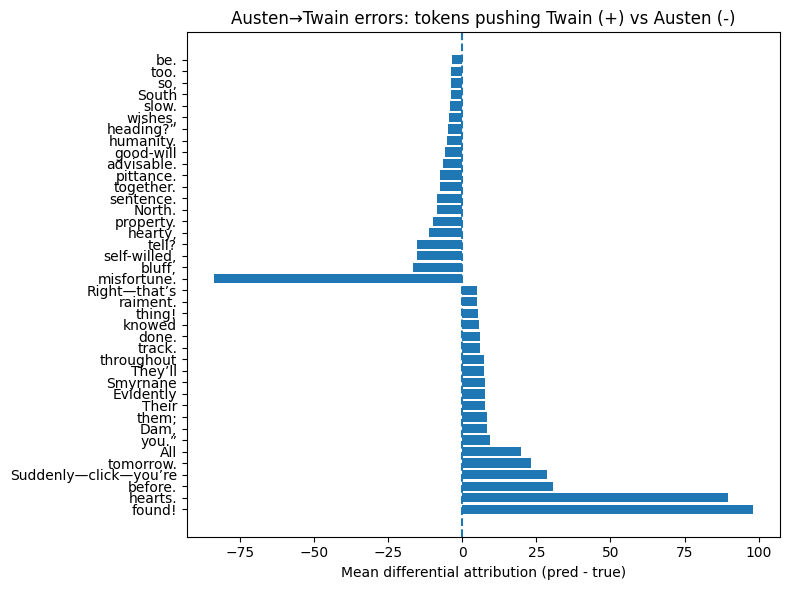

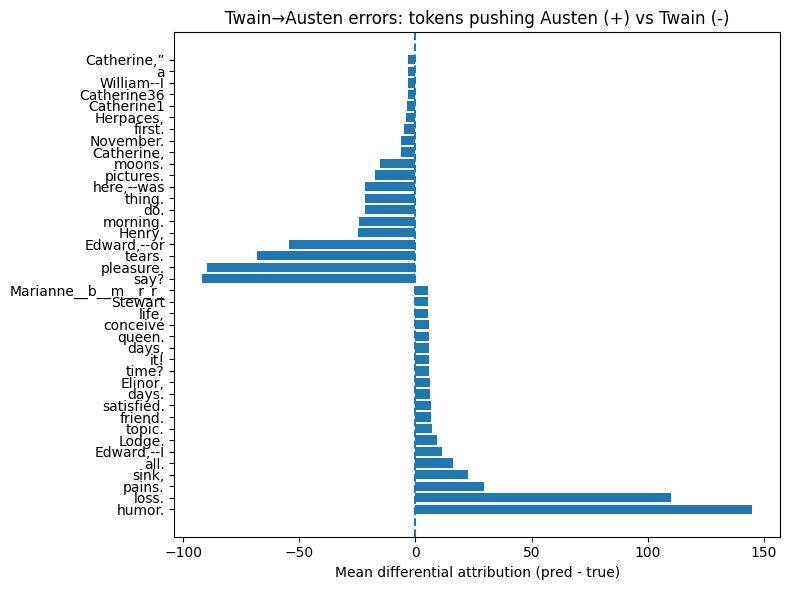

In [ ]:
# ---- CONFIG ----
PAIR_TRUE, PAIR_PRED = 1, 2      # Austen=1, Twain=2  (you can flip later)
MAXLEN = 256
N_PER_SIDE = 150                 # how many errors to sample per confusion direction
TOP_K_TOKENS = 20                # how many tokens to show in the bars

# sample errors for both directions
a_to_t = generated_texts_merged.query("expected_label==@PAIR_TRUE and predicted_Label_roberta==@PAIR_PRED")
t_to_a = generated_texts_merged.query("expected_label==@PAIR_PRED and predicted_Label_roberta==@PAIR_TRUE")

a_to_t = a_to_t.nlargest(N_PER_SIDE, "confidence") if len(a_to_t)>N_PER_SIDE else a_to_t
t_to_a = t_to_a.nlargest(N_PER_SIDE, "confidence") if len(t_to_a)>N_PER_SIDE else t_to_a

# helper to run IG on many rows and aggregate word-level diff
from collections import defaultdict

def aggregate_pair_diff(rows, true_cls, pred_cls, model, tokenizer, max_length=256, device=None):
    token2sum = defaultdict(float)
    token2cnt = defaultdict(int)
    for idx in rows.index:
        out = explain_row(generated_texts_merged, idx, model, tokenizer, max_length=max_length, device=device, top_k=999)
        pred_df, true_df = out["pred_df"], out["true_df"]
        diff = (pred_df[["word","attr"]].merge(true_df[["word","attr"]], on="word", how="outer",
                                               suffixes=("_pred","_true")).fillna(0.0))
        diff["d"] = diff["attr_pred"] - diff["attr_true"]
        for w, d in zip(diff["word"], diff["d"]):
            token2sum[w] += float(d)
            token2cnt[w] += 1
    # average diff per token
    items = [(w, token2sum[w]/max(token2cnt[w],1), token2cnt[w]) for w in token2sum]
    df = pd.DataFrame(items, columns=["word","mean_diff","count"])
    # filter trivial tokens
    df = df[~df["word"].str.match(r"^(\W+|)$")]
    return df.sort_values("mean_diff", ascending=False)

# aggregate for both directions
df_a_to_t = aggregate_pair_diff(a_to_t, true_cls=PAIR_TRUE, pred_cls=PAIR_PRED, model=model, tokenizer=tokenizer, max_length=MAXLEN)
df_t_to_a = aggregate_pair_diff(t_to_a, true_cls=PAIR_PRED, pred_cls=PAIR_TRUE, model=model, tokenizer=tokenizer, max_length=MAXLEN)

# plot top tokens pushing toward Twain (positive) and toward Austen (negative)
import matplotlib.pyplot as plt
def plot_top_tokens(df, title, k=TOP_K_TOKENS):
    top_pos = df.head(k)
    top_neg = df.tail(k).sort_values("mean_diff")
    fig, ax = plt.subplots(figsize=(8,6))
    y = list(top_pos["word"]) + list(top_neg["word"])
    x = list(top_pos["mean_diff"]) + list(top_neg["mean_diff"])
    ax.barh(y, x)
    ax.set_title(title)
    ax.set_xlabel("Mean differential attribution (pred - true)")
    ax.axvline(0, linestyle="--")
    plt.tight_layout()
    plt.show()

plot_top_tokens(df_a_to_t, "Austen→Twain errors: tokens pushing Twain (+) vs Austen (-)")
plot_top_tokens(df_t_to_a, "Twain→Austen errors: tokens pushing Austen (+) vs Twain (-)")


In [ ]:
# Token frequency vs. differential attribution

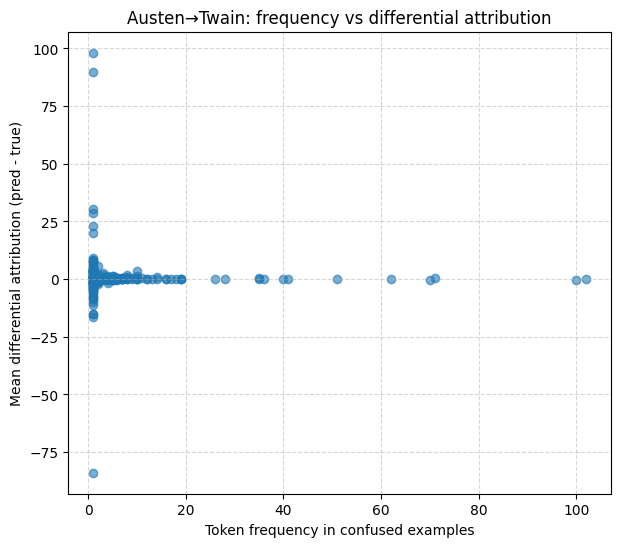

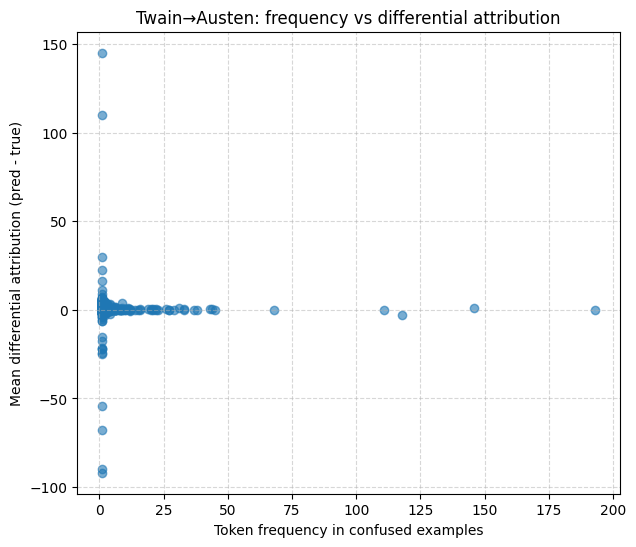

In [ ]:
def scatter_freq_vs_diff(df_diff, title):
    # approximate frequency from 'count' (how often token contributed across examples)
    freq = df_diff["count"].astype(float)
    mean_diff = df_diff["mean_diff"].astype(float)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,6))
    plt.scatter(freq, mean_diff, alpha=0.6)
    plt.xlabel("Token frequency in confused examples")
    plt.ylabel("Mean differential attribution (pred - true)")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

scatter_freq_vs_diff(df_a_to_t, "Austen→Twain: frequency vs differential attribution")
scatter_freq_vs_diff(df_t_to_a, "Twain→Austen: frequency vs differential attribution")


In [ ]:
# Prototype & counter-prototype snippets (gallery)

In [ ]:
def top_prototypes(df_pair, k=6):
    # already filtered to a confusion pair; pick by highest confidence
    return df_pair.nlargest(k, "confidence")[["Text","Expected Author","Predicted Author","confidence"]]

# Example galleries:
proto_a_to_t = top_prototypes(a_to_t, k=6)
proto_t_to_a = top_prototypes(t_to_a, k=6)
proto_a_to_t.head(), proto_t_to_a.head()

# (Optional) For each text in the gallery, call explain_row(...) then show_attribution_text(...) as you did.


(                                                    Text Expected Author  \
 22061  Among other things, he is now going to bring u...     Jane Austen   
 10466       420.jpg.jpg (22K) The day was soon breaking.     Jane Austen   
 23431      They’ll not be able to get off till tomorrow.     Jane Austen   
 39521  497.jpg (29K) “Do you think it possible?” “Why...     Jane Austen   
 31871         Neither — it was like a new world to them.     Jane Austen   
 
       Predicted Author  confidence  
 22061       Mark Twain    0.999926  
 10466       Mark Twain    0.999926  
 23431       Mark Twain    0.999888  
 39521       Mark Twain    0.999887  
 31871       Mark Twain    0.999876  ,
                                                     Text Expected Author  \
 31157  Elinor and I saw this, and were at the same ti...      Mark Twain   
 9987   Elinor watched him intently during the rest of...      Mark Twain   
 34987  Elinor was a little disturbed and somewhat dis...      Mark Twain   

In [ ]:
# Counterfactual impact of top tokens (average Δprob)

In [ ]:
def average_token_impact(df_rows, target_class, tokens, model, tokenizer, max_length=256, device=None, sample_n=100):
    rows = df_rows.nlargest(sample_n, "confidence") if len(df_rows)>sample_n else df_rows
    impacts = []
    for t in tokens:
        deltas = []
        for _, r in rows.iterrows():
            p0, _ = mask_and_score(model, tokenizer, r["Text"], target_class, max_length=max_length, device=device, words_to_mask=[])
            p1, _ = mask_and_score(model, tokenizer, r["Text"], target_class, max_length=max_length, device=device, words_to_mask=[t])
            deltas.append(p0 - p1)  # drop in prob when masking token t
        impacts.append((t, float(np.mean(deltas)), len(deltas)))
    out = pd.DataFrame(impacts, columns=["token","mean_delta_prob","n"])
    return out.sort_values("mean_delta_prob", ascending=False)

# Example: take top 15 Twain-pushing tokens from Austen→Twain errors and measure their avg impact on P(Twain)
twain_tokens = df_a_to_t.head(15)["word"].tolist()
impact_tbl = average_token_impact(a_to_t, target_class=2, tokens=twain_tokens, model=model, tokenizer=tokenizer, max_length=MAXLEN, sample_n=80)
impact_tbl.head(15)


,token,mean_delta_prob,n
7,"Dam,",1.220395e-02,80
5,All,1.122834e-02,80
3,Suddenly—click—you’re,3.805239e-03,80
14,track.,1.613371e-04,80
11,Smyrnane,1.424395e-04,80
0,found!,9.598583e-06,80
12,They’ll,9.097159e-06,80
13,throughout,4.614890e-06,80
6,you.”,0.000000e+00,80
1,hearts.,0.000000e+00,80


## ---- IntegratedGradients:

In [ ]:
# Step 1 – Setup

!pip install captum
import torch
import numpy as np
import pandas as pd
from captum.attr import IntegratedGradients
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNo

In [ ]:
def get_word_embeddings_module(model):
    for name in ["deberta", "roberta", "bert", "distilbert", "albert", "electra"]:
        if hasattr(model, name):
            emb = getattr(model, name).embeddings
            if hasattr(emb, "word_embeddings"):
                return emb.word_embeddings
    # Fallback
    if hasattr(model, "embeddings") and hasattr(model.embeddings, "word_embeddings"):
        return model.embeddings.word_embeddings
    raise AttributeError("Could not locate embeddings.word_embeddings on this model.")

def _forward_from_embeds(model, attention_mask, token_type_ids, inputs_embeds):
    out = model(
        attention_mask=attention_mask,
        token_type_ids=token_type_ids if token_type_ids is not None else None,
        inputs_embeds=inputs_embeds,
    )
    return out.logits


In [ ]:
# Attribution for a Single Sentence:

def get_token_attributions_embeds(model, tokenizer, text, target_class, max_length=128, n_steps=32, device=None):
    model.eval()
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model.to(device)

    enc = tokenizer(text, truncation=True, max_length=max_length, return_tensors="pt")
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc.get("attention_mask", None)
    attention_mask = attention_mask.to(device) if attention_mask is not None else None
    token_type_ids = enc.get("token_type_ids", None)
    token_type_ids = token_type_ids.to(device) if token_type_ids is not None else None

    we = get_word_embeddings_module(model)

    with torch.no_grad():
        inputs_embeds  = we(input_ids)                         # [1, L, H]
        pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0
        baseline_ids   = torch.full_like(input_ids, pad_id)
        baseline_embeds = we(baseline_ids)

    def target_logit_from_embeds(inp_emb):
        logits = _forward_from_embeds(model, attention_mask, token_type_ids, inp_emb)
        return logits[:, target_class]

    ig = IntegratedGradients(target_logit_from_embeds)
    # returns a single tensor when return_convergence_delta=False
    attributions = ig.attribute(
        inputs=inputs_embeds,
        baselines=baseline_embeds,
        n_steps=n_steps,
        return_convergence_delta=False,
    )

    # reduce embedding-dim → per-token score
    token_attr = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).detach().cpu().tolist())
    return tokens, token_attr


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def global_author_attributions(df, model, tokenizer,
                               sample_size=None,   # ← None = use ALL rows
                               max_length=128, n_steps=32,
                               by="Expected Author"):
    """
    Aggregate token attributions per author on df (optionally filtered before).
    by: "Expected Author" (ground-truth view) or "Predicted Author" (model-view).
    """
    import numpy as np, pandas as pd
    from tqdm import tqdm

    authors = df[by].unique().tolist()
    agg = {a: {} for a in authors}

    if sample_size is None:
        sampled = df
    else:
        sampled = df.sample(min(sample_size, len(df)), random_state=42)

    for _, row in tqdm(sampled.iterrows(), total=len(sampled)):
        text = row["Text"]
        target_cls = int(row["expected_label"]) if by == "Expected Author" else int(row["predicted_Label_roberta"])

        toks, attrs = get_token_attributions_embeds(
            model, tokenizer, text,
            target_class=target_cls, max_length=max_length, n_steps=n_steps
        )

        for tok, val in zip(toks, attrs):
            if tok in {"<s>", "</s>", "<pad>", "[CLS]", "[SEP]", "[PAD]"}:
                continue
            if tok.startswith("▁") or tok.startswith("Ġ"):
                tok = tok[1:]
            if not tok:
                continue
            a = row[by]
            agg[a][tok] = agg[a].get(tok, 0.0) + float(val)

    author_dfs = {}
    for a in authors:
        df_tok = pd.DataFrame(list(agg[a].items()), columns=["token", "total_attr"])
        df_tok["abs_attr"] = df_tok["total_attr"].abs()
        author_dfs[a] = df_tok.sort_values("abs_attr", ascending=False).reset_index(drop=True)
    return author_dfs



In [ ]:
import matplotlib.pyplot as plt

def plot_top_tokens(author_df, author_name, top_n=30):
    top_df = author_df.head(top_n)
    plt.figure(figsize=(4,6))
    plt.barh(top_df["token"], top_df["total_attr"])
    plt.gca().invert_yaxis()
    plt.title(f"Top tokens influencing: {author_name}")
    plt.xlabel("Aggregated attribution")
    plt.tight_layout()
    plt.show()


In [ ]:
high_conf_df = generated_texts_merged[generated_texts_merged["confidence"] > 0.93].copy()
print("High‑confidence samples:", len(high_conf_df))

High‑confidence samples: 40033


In [ ]:
# Step 5 – Run

author_results_all = global_author_attributions(
    high_conf_df, model, tokenizer,
    sample_size=None,      # ← use ALL high‑confidence rows
    max_length=128,        # increase to 256 if you can afford it
    n_steps=32,            # 16–32 is a good trade‑off
    by="Expected Author"   # or "Predicted Author" for model‑centric view
)

100%|██████████| 40033/40033 [1:59:36<00:00,  5.58it/s]


In [ ]:
# Save
import pickle


# Save dictionary to a pickle file
with open("author_results_all.pkl", "wb") as f:
    pickle.dump(author_results_all, f)

In [ ]:
# Load
import pickle

with open("author_results_all.pkl", "rb") as f:
    author_results_all = pickle.load(f)

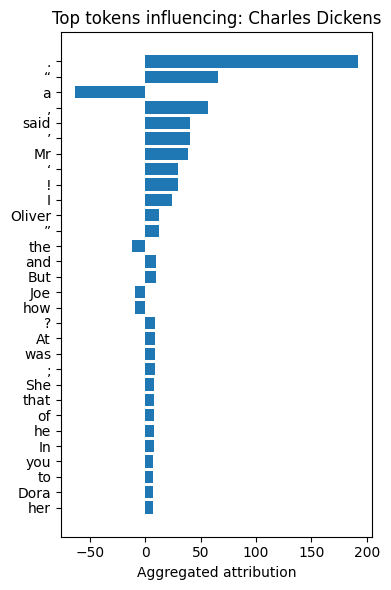

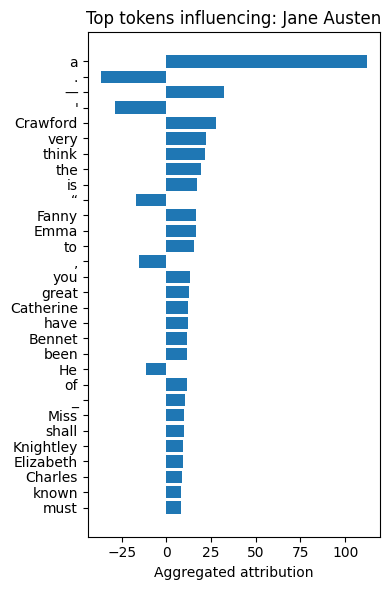

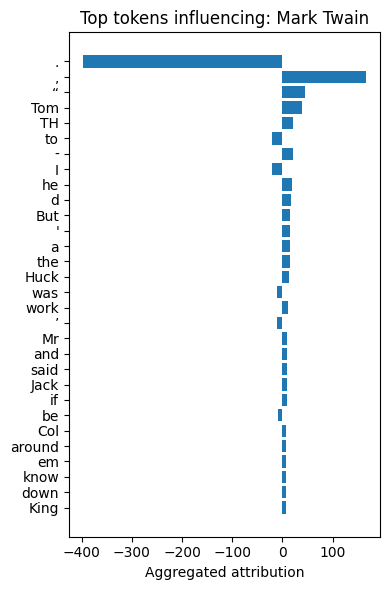

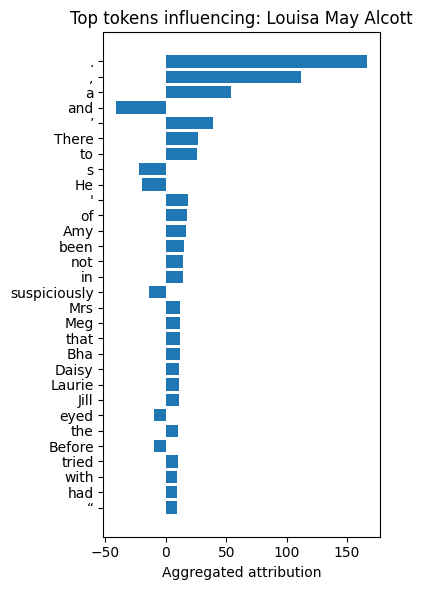

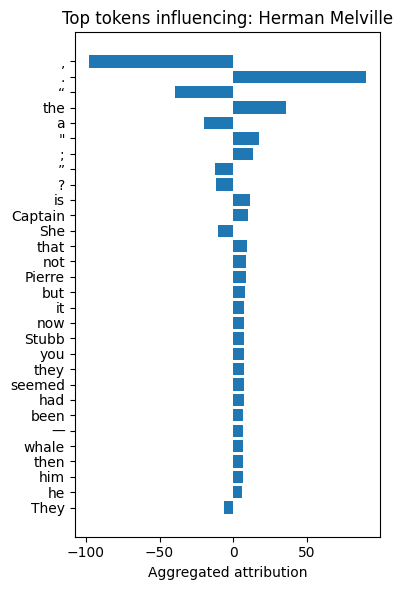

In [ ]:
for author, df_tok in author_results_all.items():
    plot_top_tokens(df_tok, author, top_n=15)

## ---- XAI Generators:

In [ ]:
!pip install captum

In [ ]:
import torch, math, random
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
from torch.nn import functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# Your paths
model = GPTNeoForCausalLM.from_pretrained(drive_model_path).to(device).eval()
tokenizer = GPT2Tokenizer.from_pretrained(drive_tokenizer_path)
tokenizer.pad_token = tokenizer.eos_token  # safety

TAGS = ["<0>", "<1>", "<2>", "<3>", "<4>"]  # Dickens, Austen, Twain, Alcott, Melville

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# (Optional) ensure the model is set to return attentions by default
model.config.output_attentions = True

@torch.no_grad()
def attention_to_from_tag_better(prompt_text, max_new_tokens=40):
    full = generate_text(prompt_text, max_new_tokens=max_new_tokens)

    enc = tokenizer(full, return_tensors="pt").to(model.device)
    out = model(**enc, output_attentions=True)
    attns = out.attentions  # tuple of [B,H,T,T]
    attn_mask = enc["attention_mask"][0].bool()  # [T]
    T = int(attn_mask.sum().item())              # exclude PAD at the tail
    valid_idx = torch.arange(enc["input_ids"].size(1), device=model.device)[attn_mask]

    # Find tag span at the start (like before)
    text_stripped = prompt_text.lstrip()
    tag = next((t for t in TAGS if text_stripped.startswith(t)), None)
    if tag is None:
        tag = text_stripped.split()[0] if text_stripped else TAGS[0]
    tag_ids = tokenizer(tag, add_special_tokens=False)["input_ids"]
    if prompt_text.startswith(tag + " "):
        tag_ids_space = tokenizer(tag + " ", add_special_tokens=False)["input_ids"]
        if tag_ids_space == enc["input_ids"][0, :len(tag_ids_space)].tolist():
            tag_ids = tag_ids_space

    tag_start, tag_end = 0, len(tag_ids)  # exclusive
    tag_len = tag_end - tag_start

    layer_stats = []
    for A in attns:  # [B,H,T,T]
        A = A.squeeze(0)[:, attn_mask, :][:, :, attn_mask]  # [H, T, T] over valid tokens only
        A_mean = A.mean(dim=0)  # average over heads -> [T,T]

        # ---- TO TAG ----
        to_tag_mass = A_mean[:, tag_start:tag_end].mean().item()
        baseline_to_tag = tag_len / T
        to_tag_enrichment = to_tag_mass / baseline_to_tag if baseline_to_tag > 0 else float('nan')

        # ---- FROM TAG (meaningful) ----
        tag_rows = A_mean[tag_start:tag_end, :]  # [tag_len, T]
        # exclude the tag columns when measuring broadcast
        non_tag_cols = torch.cat([torch.arange(0, tag_start, device=model.device),
                                  torch.arange(tag_end, T, device=model.device)])
        if non_tag_cols.numel() > 0:
            from_tag_non_tag_mean = tag_rows[:, non_tag_cols].mean().item()
            from_tag_max = tag_rows[:, non_tag_cols].max().item()
        else:
            from_tag_non_tag_mean = float('nan')
            from_tag_max = float('nan')

        layer_stats.append({
            "to_tag": to_tag_mass,
            "to_tag_enrichment": to_tag_enrichment,
            "from_tag_non_tag_mean": from_tag_non_tag_mean,
            "from_tag_max": from_tag_max,
            "T": T,
            "tag_len": tag_len
        })

    return full, layer_stats


In [ ]:
# Example usage
full, stats = attention_to_from_tag_better("<0>")
for L, s in enumerate(stats):
    print(f"Layer {L:02d}: to_tag={s['to_tag']:.4f} (x{s['to_tag_enrichment']:.1f}), "
          f"from_tag_mean(non-tag)={s['from_tag_non_tag_mean']:.4f}, "
          f"from_tag_max={s['from_tag_max']:.4f}")
print("\nSample:\n", full)


Layer 00: to_tag=0.0361 (x0.6), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 01: to_tag=0.0873 (x1.5), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 02: to_tag=0.1246 (x2.2), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 03: to_tag=0.0864 (x1.5), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 04: to_tag=0.0463 (x0.8), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 05: to_tag=0.0412 (x0.7), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 06: to_tag=0.0525 (x0.9), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 07: to_tag=0.0428 (x0.8), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 08: to_tag=0.1251 (x2.2), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 09: to_tag=0.0676 (x1.2), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 10: to_tag=0.2357 (x4.2), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 11: to_tag=0.1109 (x2.0), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Laye

In [ ]:
# Example usage
full, stats = attention_to_from_tag_better("<1>")
for L, s in enumerate(stats):
    print(f"Layer {L:02d}: to_tag={s['to_tag']:.4f} (x{s['to_tag_enrichment']:.1f}), "
          f"from_tag_mean(non-tag)={s['from_tag_non_tag_mean']:.4f}, "
          f"from_tag_max={s['from_tag_max']:.4f}")
print("\nSample:\n", full)


Layer 00: to_tag=0.0502 (x0.7), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 01: to_tag=0.1038 (x1.5), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 02: to_tag=0.1378 (x2.0), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 03: to_tag=0.0918 (x1.3), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 04: to_tag=0.0534 (x0.8), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 05: to_tag=0.0522 (x0.7), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 06: to_tag=0.0619 (x0.9), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 07: to_tag=0.0471 (x0.7), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 08: to_tag=0.1304 (x1.9), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 09: to_tag=0.0646 (x0.9), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 10: to_tag=0.2323 (x3.3), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 11: to_tag=0.0885 (x1.3), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Laye

In [ ]:
# Example usage
full, stats = attention_to_from_tag_better("<2> ")
for L, s in enumerate(stats):
    print(f"Layer {L:02d}: to_tag={s['to_tag']:.4f} (x{s['to_tag_enrichment']:.1f}), "
          f"from_tag_mean(non-tag)={s['from_tag_non_tag_mean']:.4f}, "
          f"from_tag_max={s['from_tag_max']:.4f}")
print("\nSample:\n", full)


Layer 00: to_tag=0.0331 (x0.6), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 01: to_tag=0.0674 (x1.2), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 02: to_tag=0.0874 (x1.5), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 03: to_tag=0.0561 (x1.0), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 04: to_tag=0.0324 (x0.6), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 05: to_tag=0.0293 (x0.5), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 06: to_tag=0.0342 (x0.6), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 07: to_tag=0.0294 (x0.5), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 08: to_tag=0.0555 (x1.0), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 09: to_tag=0.0354 (x0.6), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 10: to_tag=0.1223 (x2.1), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 11: to_tag=0.0555 (x1.0), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Laye

In [ ]:
# Example usage
full, stats = attention_to_from_tag_better("<3> ")
for L, s in enumerate(stats):
    print(f"Layer {L:02d}: to_tag={s['to_tag']:.4f} (x{s['to_tag_enrichment']:.1f}), "
          f"from_tag_mean(non-tag)={s['from_tag_non_tag_mean']:.4f}, "
          f"from_tag_max={s['from_tag_max']:.4f}")
print("\nSample:\n", full)


Layer 00: to_tag=0.0435 (x0.5), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 01: to_tag=0.0864 (x1.0), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 02: to_tag=0.1224 (x1.3), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 03: to_tag=0.0890 (x1.0), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 04: to_tag=0.0463 (x0.5), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 05: to_tag=0.0510 (x0.6), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 06: to_tag=0.0553 (x0.6), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 07: to_tag=0.0439 (x0.5), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 08: to_tag=0.1183 (x1.3), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 09: to_tag=0.0569 (x0.6), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 10: to_tag=0.2024 (x2.2), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 11: to_tag=0.0784 (x0.9), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Laye

In [ ]:
# Example usage
full, stats = attention_to_from_tag_better("<4> ")
for L, s in enumerate(stats):
    print(f"Layer {L:02d}: to_tag={s['to_tag']:.4f} (x{s['to_tag_enrichment']:.1f}), "
          f"from_tag_mean(non-tag)={s['from_tag_non_tag_mean']:.4f}, "
          f"from_tag_max={s['from_tag_max']:.4f}")
print("\nSample:\n", full)


Layer 00: to_tag=0.0422 (x0.5), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 01: to_tag=0.0799 (x0.9), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 02: to_tag=0.1145 (x1.3), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 03: to_tag=0.0788 (x0.9), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 04: to_tag=0.0462 (x0.5), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 05: to_tag=0.0514 (x0.6), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 06: to_tag=0.0531 (x0.6), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 07: to_tag=0.0416 (x0.5), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 08: to_tag=0.1023 (x1.1), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 09: to_tag=0.0579 (x0.6), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 10: to_tag=0.1922 (x2.1), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Layer 11: to_tag=0.0715 (x0.8), from_tag_mean(non-tag)=0.0000, from_tag_max=0.0000
Laye

In [ ]:
################################

In [ ]:
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval();

In [ ]:
# Generation (explain one sample)

@torch.no_grad()
def generate_once(prompt, max_new_tokens=40, temperature=0.8, top_p=0.95, seed=42):
    torch.manual_seed(seed)
    enc = tokenizer(prompt, return_tensors="pt").to(device)
    out_ids = model.generate(
        **enc,
        do_sample=True,
        top_p=top_p,
        temperature=temperature,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id
    )[0]
    text = tokenizer.decode(out_ids, skip_special_tokens=True)
    return out_ids.unsqueeze(0), text  # [1, T], string


# Integrated Gradients

def build_baseline_and_inputs(input_ids, prompt_len):
    with torch.no_grad():
        base_no_grad = model.transformer.wte(input_ids)  # [1, T, d]
    # Captum will backprop through 'inputs' only; they must require_grad=True
    inputs_embeds = base_no_grad.clone().detach().requires_grad_(True)

    baseline = torch.zeros_like(inputs_embeds)
    # keep generated part fixed in both baseline and inputs to focus attribution on prompt
    baseline[:, prompt_len:, :] = base_no_grad[:, prompt_len:, :]
    return inputs_embeds, baseline

def token_logprob_from_embeds(embeds, attention_mask, target_index, target_token_id):
    """
    Returns shape (1,) tensor with log P(x[target_index] | x[:target_index]).
    """
    outputs = model(inputs_embeds=embeds, attention_mask=attention_mask)
    logits = outputs.logits  # [1, T, V]
    logprobs = F.log_softmax(logits[:, :-1, :], dim=-1)
    pred_pos = target_index - 1
    lp_scalar = logprobs[0, pred_pos, target_token_id]  # 0-dim scalar
    return lp_scalar.unsqueeze(0)  # -> shape (1,)

from captum.attr import IntegratedGradients

def compute_ig_matrix_for_generation(input_ids, prompt_len, n_steps=32, internal_bs=1):
    attention_mask = torch.ones_like(input_ids, device=input_ids.device)
    T = input_ids.size(1)
    gen_start = prompt_len
    gen_len = T - gen_start

    all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
    prompt_tokens = all_tokens[:prompt_len]
    gen_tokens = all_tokens[gen_start:]

    # embeddings to attribute + baseline (both on device)
    inputs_embeds, baseline = build_baseline_and_inputs(input_ids, prompt_len)

    ig_matrix = np.zeros((prompt_len, gen_len), dtype=np.float32)

    for j_abs in range(gen_start, T):
        target_token_id = input_ids[0, j_abs].item()

        # forward that returns (1,) tensor for Captum
        def forward_scalar(embeds):
            return token_logprob_from_embeds(
                embeds, attention_mask, j_abs, target_token_id
            )

        ig = IntegratedGradients(forward_scalar)

        # IMPORTANT: pass inputs that require grad; baseline need not require grad
        attributions, _ = ig.attribute(
            inputs=inputs_embeds,
            baselines=baseline,
            n_steps=n_steps,
            internal_batch_size=internal_bs,
            return_convergence_delta=True
        )

        tok_scores = attributions.norm(dim=-1).squeeze(0)  # [T]
        ig_matrix[:, j_abs - gen_start] = tok_scores[:prompt_len].detach().cpu().numpy()

    return ig_matrix, prompt_tokens, gen_tokens


# Plotting utilities

def plot_heatmap(ig_matrix, prompt_tokens, gen_tokens, title="Token Attribution Heatmap (IG)"):
    plt.figure(figsize=(min(18, 2 + 0.3 * len(gen_tokens)), min(10, 2 + 0.25 * len(prompt_tokens))))
    im = plt.imshow(ig_matrix, aspect='auto', interpolation='nearest')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(ticks=np.arange(len(gen_tokens)), labels=gen_tokens, rotation=90)
    plt.yticks(ticks=np.arange(len(prompt_tokens)), labels=prompt_tokens)
    plt.xlabel("Generated tokens")
    plt.ylabel("Prompt tokens (incl. tag)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_prompt_importance(ig_matrix, prompt_tokens, title="Prompt Token Importance (sum over generated)"):
    scores = ig_matrix.sum(axis=1)
    plt.figure(figsize=(max(6, 0.4 * len(prompt_tokens)), 3.5))
    plt.bar(range(len(prompt_tokens)), scores)
    plt.xticks(range(len(prompt_tokens)), prompt_tokens, rotation=90)
    plt.ylabel("IG magnitude (sum over generated)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# One-call helper

def explain_generation_with_ig(prompt, max_new_tokens=40, n_steps=32, seed=42):
    input_ids, full_text = generate_once(prompt, max_new_tokens=max_new_tokens, seed=seed)
    prompt_len = len(tokenizer(prompt)["input_ids"])

    ig_matrix, prompt_tokens, gen_tokens = compute_ig_matrix_for_generation(
        input_ids.to(device), prompt_len, n_steps=n_steps
    )
    print("FULL TEXT:\n", tokenizer.decode(input_ids[0], skip_special_tokens=True))
    plot_heatmap(ig_matrix, prompt_tokens, gen_tokens,
                 title=f"IG Heatmap | prompt='{prompt.strip()}'")
    plot_prompt_importance(ig_matrix, prompt_tokens)

FULL TEXT:
 <0> “Aha!” said the spy, with a long draggled breath. <end> [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


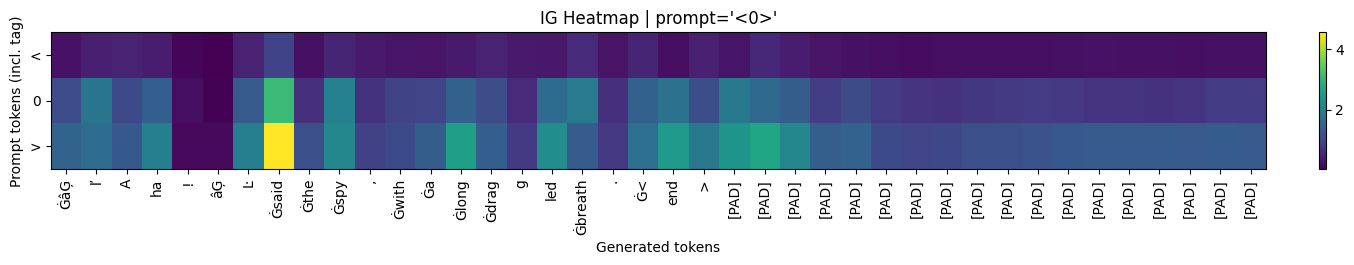

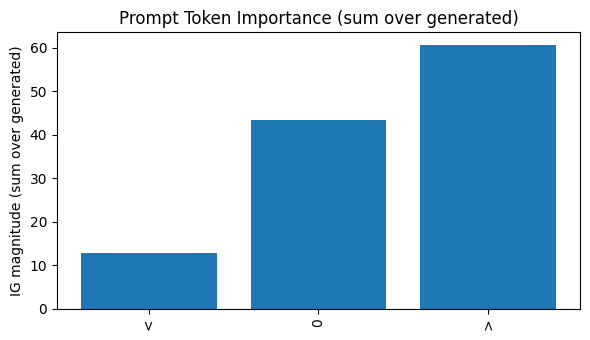

In [ ]:
# Run it (example)

# Use your tags as the prompt start (e.g., "<0> ", "<1> ", etc.)

explain_generation_with_ig("<0>", max_new_tokens=40, n_steps=32, seed=123)

FULL TEXT:
 <1> I am the happiest creature in the world. <end> [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


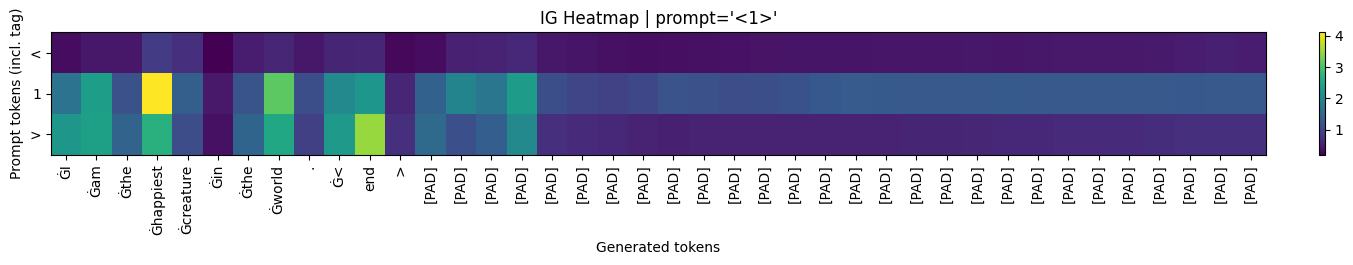

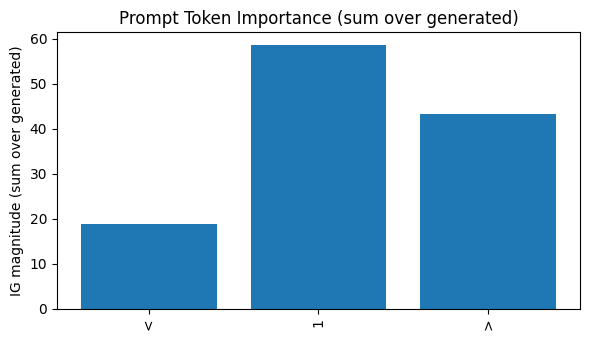

In [ ]:
# Run it (example)

# Use your tags as the prompt start (e.g., "<0> ", "<1> ", etc.)

explain_generation_with_ig("<1>", max_new_tokens=40, n_steps=32, seed=123)

FULL TEXT:
 <2> The place has been picketed since the late war. <end> [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


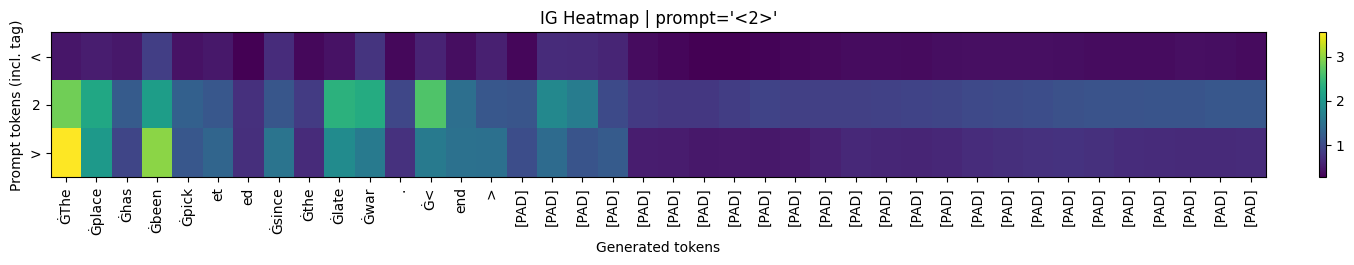

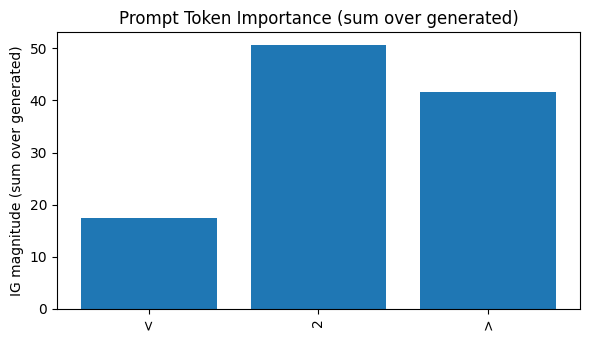

In [ ]:
# Run it (example)

# Use your tags as the prompt start (e.g., "<0> ", "<1> ", etc.)

explain_generation_with_ig("<2>", max_new_tokens=40, n_steps=32, seed=123)

FULL TEXT:
 <3> “Aunt Jessie is very ill, and I don't know what I shall do for her. <end> [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


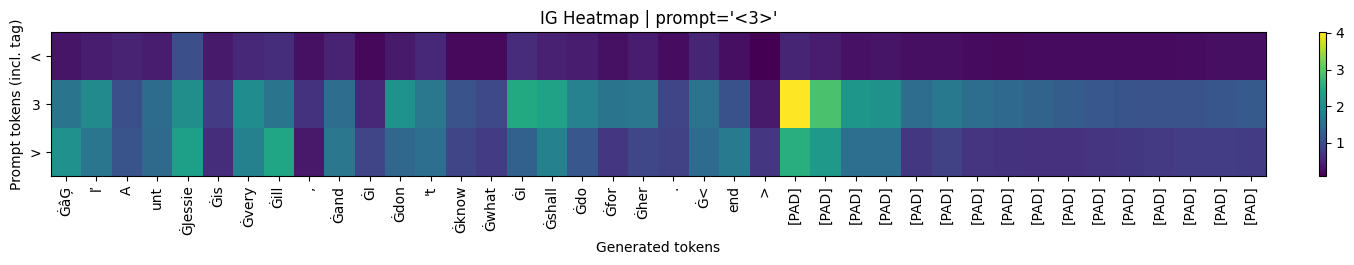

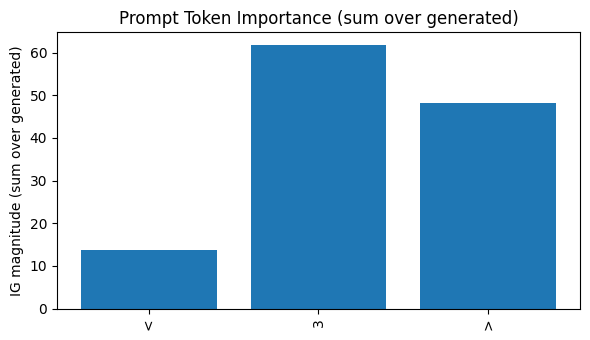

In [ ]:
# Run it (example)

# Use your tags as the prompt start (e.g., "<0> ", "<1> ", etc.)

explain_generation_with_ig("<3>", max_new_tokens=40, n_steps=32, seed=123)

FULL TEXT:
 <4> The Commodore, like the Emperor of foreign nations, is a creature of a sort; possessing a high degree of conscious independence of mind, and a great deal of that high-pitched humbuggery


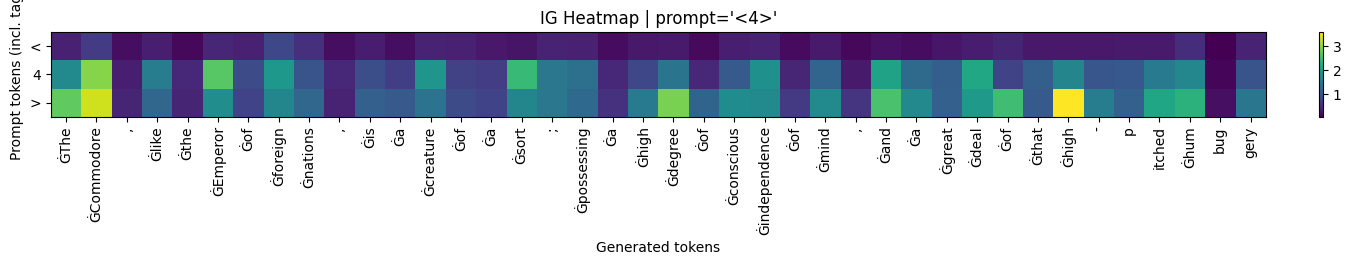

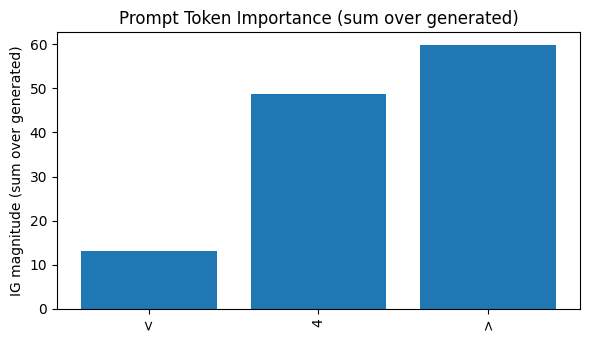

In [ ]:
# Run it (example)

# Use your tags as the prompt start (e.g., "<0> ", "<1> ", etc.)

explain_generation_with_ig("<4>", max_new_tokens=40, n_steps=32, seed=123)

In [ ]:
# Attention Head Visualizations

In [ ]:
model = GPTNeoForCausalLM.from_pretrained(drive_model_path).to(device).eval()
tokenizer = GPT2Tokenizer.from_pretrained(drive_tokenizer_path)
tokenizer.pad_token = tokenizer.eos_token
device = "cuda" if torch.cuda.is_available() else "cpu"


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def generate_once(prompt, max_new_tokens=40, temperature=0.8, top_p=0.95, seed=123):
    torch.manual_seed(seed)
    enc = tokenizer(prompt, return_tensors="pt").to(device)
    out = model.generate(
        **enc,
        do_sample=True, top_p=top_p, temperature=temperature,
        max_new_tokens=max_new_tokens, pad_token_id=tokenizer.eos_token_id
    )[0]
    text = tokenizer.decode(out, skip_special_tokens=True)
    return out.unsqueeze(0), text  # [1, T], string

@torch.no_grad()
def forward_with_attn(input_ids):
    out = model(input_ids=input_ids, output_attentions=True, output_hidden_states=False)
    # out.attentions: tuple(len=num_layers) of [1, num_heads, T, T]
    return out.attentions


In [ ]:
def tag_span_indices(prompt_text):
    # Tokenize the exact prompt; the tag is at the start of the prompt
    ids = tokenizer(prompt_text, return_tensors="pt")["input_ids"][0].tolist()
    # If you pass prompt like "<0> " this returns however many subtokens that is.
    return list(range(len(ids)))  # tag is the whole prompt here


In [ ]:
def tag_len_for(tag_text):
    return len(tokenizer(tag_text)["input_ids"])


In [ ]:
def plot_attn_matrix(mat, tokens, title):
    plt.figure(figsize=(min(18, 2 + 0.25*len(tokens)), min(18, 2 + 0.25*len(tokens))))
    im = plt.imshow(mat, interpolation="nearest", aspect="auto", cmap="Blues")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.yticks(range(len(tokens)), tokens)
    plt.xlabel("Key (attended-to) tokens →")
    plt.ylabel("Query (attending) tokens →")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def tokens_for(ids):
    return tokenizer.convert_ids_to_tokens(ids[0].tolist())


In [ ]:
@torch.no_grad()
def visualize_attention_overview(prompt, max_new_tokens=40, seed=123, layers_to_show=(0, 6, 12, 18, 23)):
    ids, text = generate_once(prompt, max_new_tokens=max_new_tokens, seed=seed)
    ids, toks = trim_to_nonpad(ids)   # <-- trim out [PAD]s
    attns = forward_with_attn(ids.to(device))  # [1,H,T,T]

    print("FULL TEXT:\n", tokenizer.decode(ids[0], skip_special_tokens=True))

    tag_idx = tag_span_indices(prompt)
    tag_mask = np.zeros(len(toks), dtype=bool)
    tag_mask[tag_idx] = True

    # Layer-avg heatmaps
    for L in layers_to_show:
        A = attns[L].mean(dim=1).squeeze(0).detach().cpu().numpy()
        plot_attn_matrix(A, toks, title=f"Layer {L} — attention (avg over heads)")

    # Attention to/from tag profile
    to_tag, from_tag = [], []
    for L in range(len(attns)):
        A = attns[L].mean(dim=1).squeeze(0).detach().cpu().numpy()
        to_tag.append(A[:, tag_mask].mean())
        from_tag.append(A[tag_mask, :].mean())

    Ls = np.arange(len(attns))
    plt.figure(figsize=(10,4))
    plt.plot(Ls, to_tag, marker="o", label="to tag (←)")
    plt.plot(Ls, from_tag, marker="o", label="from tag (→)")
    plt.xlabel("Layer"); plt.ylabel("Mean attention weight")
    plt.title("Attention to/from TAG across layers")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()


In [ ]:
@torch.no_grad()
def visualize_layer_heads(prompt, layer=12, max_new_tokens=40, seed=123, head_limit=None):
    ids, _ = generate_once(prompt, max_new_tokens=max_new_tokens, seed=seed)
    ids, toks = trim_to_nonpad(ids)   # <-- trim out [PAD]s
    attns = forward_with_attn(ids.to(device))
    A = attns[layer].squeeze(0).detach().cpu().numpy()  # [H,T,T]
    H, T, _ = A.shape
    if head_limit is not None:
        H = min(H, head_limit)
        A = A[:H]

    cols = min(4, H)
    rows = int(np.ceil(H / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = np.array(axes).reshape(-1)

    for h in range(H):
        ax = axes[h]
        im = ax.imshow(A[h], interpolation="nearest", aspect="auto", cmap="Blues")
        ax.set_title(f"Layer {layer} · Head {h}")
        ax.set_xticks(range(T)); ax.set_xticklabels(toks, rotation=90, fontsize=8)
        ax.set_yticks(range(T)); ax.set_yticklabels(toks, fontsize=8)
    for k in range(H, len(axes)): axes[k].axis("off")
    fig.colorbar(im, ax=axes[:H].tolist(), fraction=0.015, pad=0.01)
    plt.tight_layout(); plt.show()


In [ ]:
def trim_to_nonpad(input_ids):
    """Trim tokens and IDs at the first [PAD]."""
    toks = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
    if "[PAD]" in toks:
        cutoff = toks.index("[PAD]")
        toks = toks[:cutoff]
        input_ids = input_ids[:, :cutoff]
    return input_ids, toks

In [ ]:
@torch.no_grad()
def plot_to_tag_for_head(prompt, layer=12, head=0, max_new_tokens=40, seed=123):
    ids, _ = generate_once(prompt, max_new_tokens=max_new_tokens, seed=seed)
    ids, toks = trim_to_nonpad(ids)   # <-- trim out [PAD]s
    attn = forward_with_attn(ids.to(device))[layer][0, head]  # [T,T]
    tag_idx = tag_span_indices(prompt)
    tag_mask = torch.zeros(attn.size(1), dtype=torch.bool, device=attn.device)
    tag_mask[tag_idx] = True
    to_tag = attn[:, tag_mask].mean(dim=1).detach().cpu().numpy()

    plt.figure(figsize=(max(8, 0.35*len(toks)), 3.5))
    plt.bar(range(len(toks)), to_tag)
    plt.xticks(range(len(toks)), toks, rotation=90)
    plt.ylabel("Attention → TAG")
    plt.title(f"Layer {layer}, Head {head}")
    plt.tight_layout()
    plt.show()


FULL TEXT:
 <1>  “A most admirable hit, upon my word. <end>


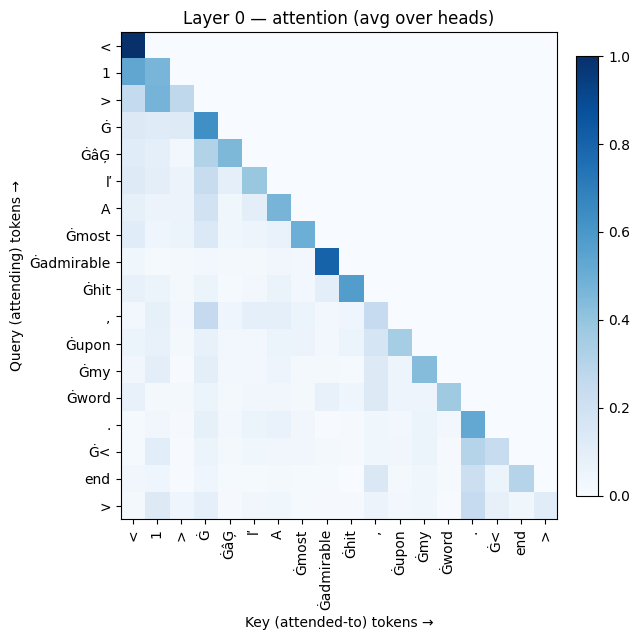

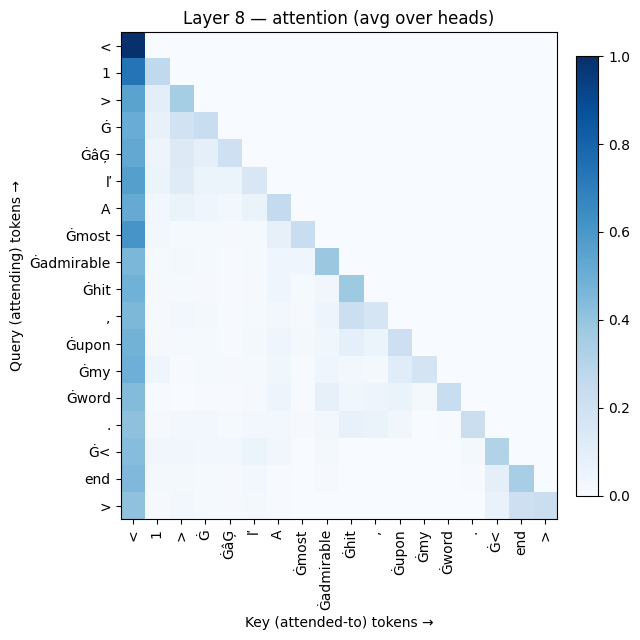

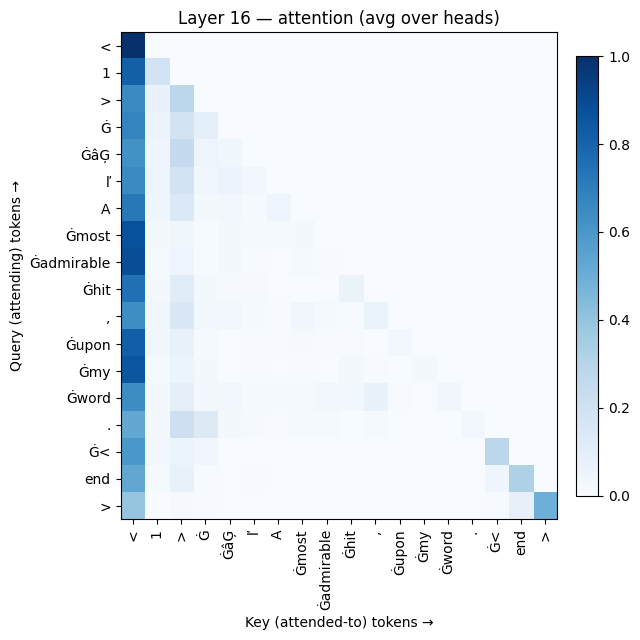

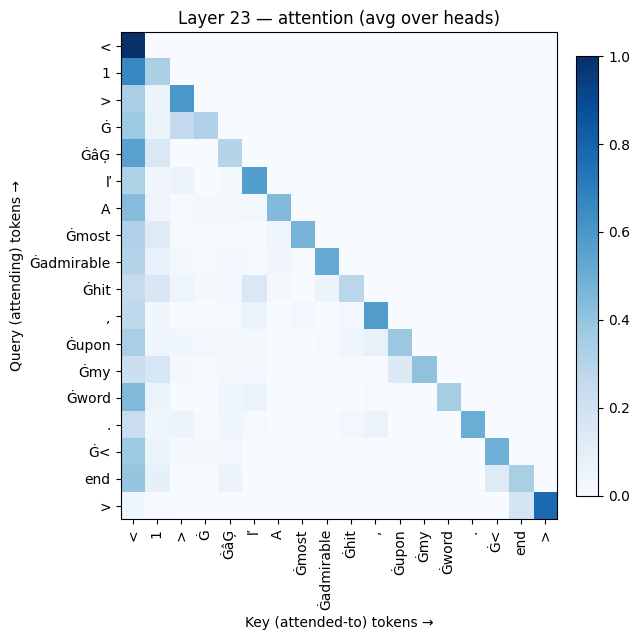

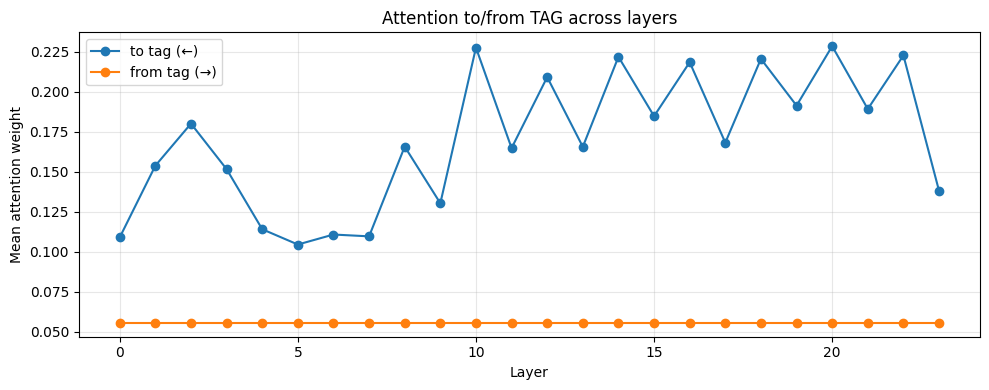

/tmp/ipython-input-1026496562.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


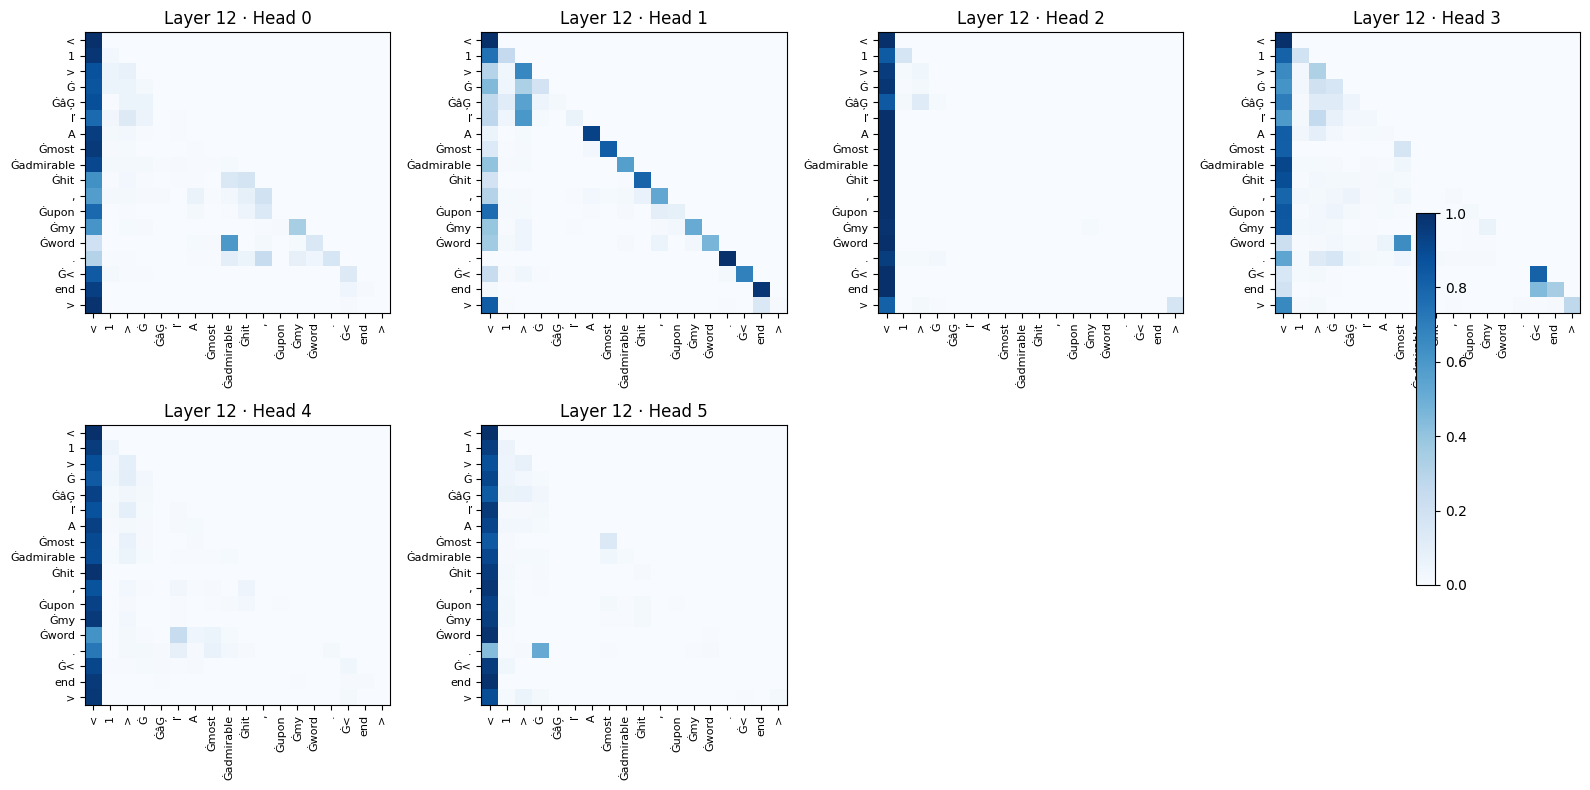

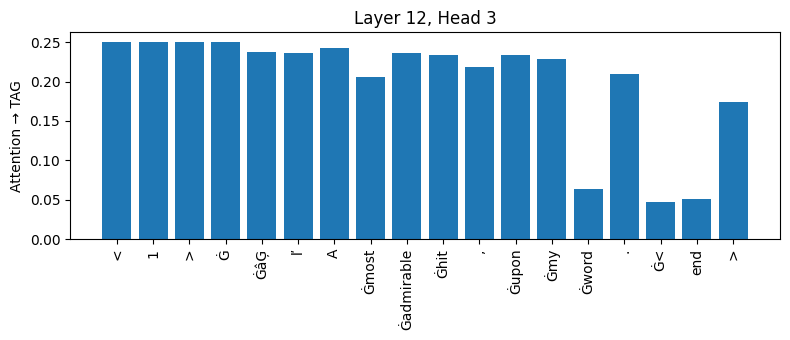

In [ ]:
# A) Overview across selected layers + tag profile
visualize_attention_overview("<1> ", max_new_tokens=40, seed=123, layers_to_show=(0, 8, 16, 23))

# B) Grid of heads for one layer
visualize_layer_heads("<1> ", layer=12, head_limit=6)

# C) Focused: which tokens attend most to the tag in a specific head?
plot_to_tag_for_head("<1> ", layer=12, head=3)


In [ ]:
# Counterfactual Comparison Plots

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(drive_tokenizer_path, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
@torch.no_grad()
def generate_once(prompt, max_new_tokens=60, temperature=0.8, top_p=0.95, seed=123):
    torch.manual_seed(seed)
    enc = tokenizer(prompt, return_tensors="pt").to(device)
    out = model.generate(
        **enc,
        do_sample=True, top_p=top_p, temperature=temperature,
        max_new_tokens=max_new_tokens, pad_token_id=tokenizer.eos_token_id
    )[0]
    text = tokenizer.decode(out, skip_special_tokens=True)
    return text

def _token_strings(input_ids):
    return tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

def _group_tokens_into_words(token_strs):
    """
    Heuristic for GPT-2 byte-BPE:
    - Start a new word when a token string begins with a space ' '.
    - Otherwise, append to the current word.
    Returns: words, word_indices (len=number of tokens, mapping token->word_id)
    """
    words, word_indices = [], []
    cur = ""
    wid = -1
    for s in token_strs:
        # Decode byte-BPE artifacts for display only
        piece = tokenizer.convert_tokens_to_string([s])
        starts_new = piece.startswith(" ")
        if starts_new or wid == -1:
            if cur:
                words.append(cur)
            cur = piece.lstrip()
            wid += 1
        else:
            cur += piece
        word_indices.append(wid)
    if cur:
        words.append(cur)
    return words, word_indices

def score_with_tag(tag, continuation_text):
    """
    Score exact string: [tag + ' ' + continuation_text]
    Aggregate token log-probs into words via byte-BPE spacing heuristic.
    """
    text = f"{tag} {continuation_text}".strip()
    enc = tokenizer(text, return_tensors="pt").to(device)
    input_ids = enc["input_ids"]    # [1, T]
    attn = enc["attention_mask"]

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attn).logits  # [1,T,V]
        logprobs = F.log_softmax(logits[:, :-1, :], dim=-1)
        tgt = input_ids[:, 1:]
        tok_lp = logprobs.gather(-1, tgt.unsqueeze(-1)).squeeze(-1)[0]   # [T-1]

    # Figure out token positions belonging to the continuation (exclude tag tokens)
    tag_len = len(tokenizer(tag)["input_ids"])
    # Prediction positions corresponding to continuation targets are indices [tag_len-1 ... T-2]
    cont_tok_lp = tok_lp[tag_len-1:]                   # [N_cont_tokens]
    cont_token_ids = input_ids[:, tag_len:].cpu()      # tokens that were predicted

    token_strs = _token_strings(cont_token_ids)
    words, word_idx = _group_tokens_into_words(token_strs)

    # Sum token log-probs into their word bins
    contrib = np.zeros(len(words), dtype=float)
    for k, lp in enumerate(cont_tok_lp.cpu().numpy()):
        w = word_idx[k]
        if 0 <= w < len(words):
            contrib[w] += lp

    total_logprob = float(cont_tok_lp.sum())
    token_count = int(cont_tok_lp.numel())
    return list(zip(words, contrib.tolist())), total_logprob, token_count

def make_counterfactual_plots(tag_a, tag_b, suffix="", max_new_tokens=60, seed=123):
    # Generate with Tag A; keep the continuation fixed
    gen_text = generate_once(f"{tag_a} {suffix}".strip(),
                             max_new_tokens=max_new_tokens, seed=seed)
    cont = gen_text.replace(tag_a, "", 1).strip()

    # Score same continuation under A and B
    words_A, total_A, nA = score_with_tag(tag_a, cont)
    words_B, total_B, nB = score_with_tag(tag_b, cont)

    words = [w for w,_ in words_A]
    a_vals = np.array([v for _,v in words_A])
    b_vals = np.array([v for _,v in words_B])
    delta = a_vals - b_vals

    # Plots
    plt.figure(figsize=(min(14, 0.5*len(words)+4), 4))
    plt.bar(range(len(words)), delta)
    plt.xticks(range(len(words)), words, rotation=90)
    plt.ylabel("Δ logP (A − B)")
    plt.title(f"Word-level preference: {tag_a} vs {tag_b}")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(min(14, 0.5*len(words)+4), 3.5))
    plt.plot(np.cumsum(delta))
    plt.xlabel("Word position →")
    plt.ylabel("Cumulative Δ logP (A − B)")
    plt.title("Cumulative preference along the continuation")
    plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    total_delta = total_A - total_B
    ppl_A = np.exp(-total_A / max(1, nA))
    ppl_B = np.exp(-total_B / max(1, nB))
    print("=== Counterfactual summary (same continuation) ===")
    print(f"Continuation (first 200 chars): {cont[:200]!r}")
    print(f"Total logP (A={tag_a}): {total_A:.2f}   | tokens: {nA}   | approx ppl: {ppl_A:.2f}")
    print(f"Total logP (B={tag_b}): {total_B:.2f}   | tokens: {nB}   | approx ppl: {ppl_B:.2f}")
    print(f"Δ logP (A − B): {total_delta:.2f}  →  {'A preferred' if total_delta>0 else 'B preferred'}")

    return {
        "continuation": cont,
        "words": words,
        "delta_per_word": delta.tolist(),
        "total_logprob_A": total_A,
        "total_logprob_B": total_B,
        "total_delta": float(total_delta),
        "ppl_A": float(ppl_A),
        "ppl_B": float(ppl_B),
    }

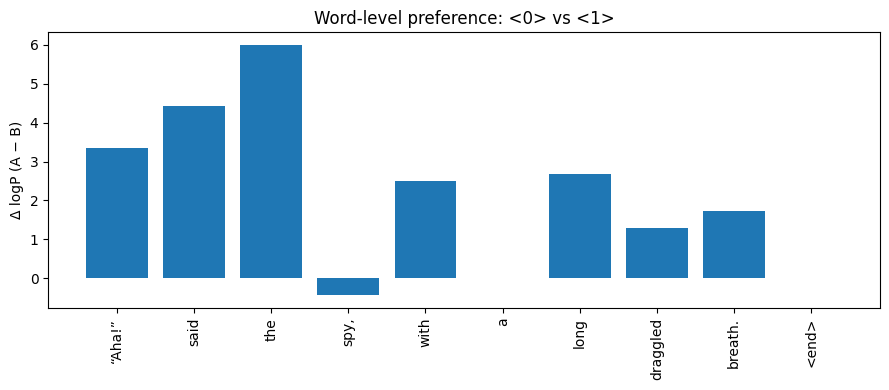

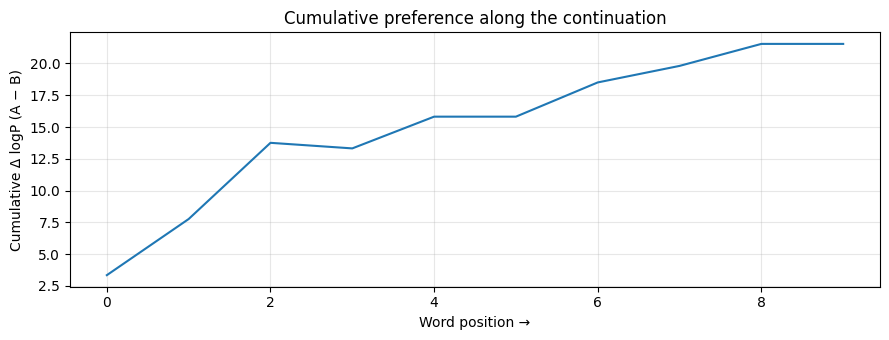

=== Counterfactual summary (same continuation) ===
Continuation (first 200 chars): '“Aha!” said the spy, with a long draggled breath. <end>'
Total logP (A=<0>): -25.20   | tokens: 22   | approx ppl: 3.14
Total logP (B=<1>): -46.79   | tokens: 22   | approx ppl: 8.39
Δ logP (A − B): 21.59  →  A preferred


In [ ]:
# Compare Dickens (<0>) vs Austen (<1>) on the same continuation
res = make_counterfactual_plots("<0>", "<1>", suffix="", max_new_tokens=60, seed=123)

# Try other pairs:
# make_counterfactual_plots("<2>", "<4>", suffix="On the river", seed=7)